In [ ]:
!pip install lightkurve pytransit

In [ ]:
!pip install arviz xarray tables uncertainties numba tqdm semantic_version setuptools deprecated seaborn emcee ldtk pyopencl corner celerite pyrr

In [69]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import ndimage
from scipy.fft import fft, fftfreq
from scipy.interpolate import approximate_taylor_polynomial, interp1d
import scipy
from astropy.units import Quantity
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from sklearn.cluster import DBSCAN
from scipy.signal import find_peaks, peak_prominences
from pytransit import QuadraticModel, RoadRunnerModel, UniformModel
from scipy.optimize import curve_fit
import astropy.constants as constants

%matplotlib inline

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140

In [19]:
def normalise(data):
    max_val = max(data)
    min_val = min(data)
    from_zero = data - min_val
    data_range = max_val - min_val
    to_return = []
    if data_range == 0:
        print("RANGE IS ZERO; SKIPING")
        print(data)
        print(data_range)
        return data
    return np.nan_to_num((data - min_val) / data_range, nan=0)

def average(data):
    data = np.nan_to_num(data, nan=0)
    return sum(data) / len(data)

def moving_average(data, n=5):
    rolling_averages = []
    for i in range(len(data) + n):
        from_i = max(0, min(i - round(n / 2), len(data) - 1))
        to_i = min(len(data) - 1, i + round(n / 2))
        sample = np.array([data[from_i]]) if to_i <= from_i else data[from_i:to_i]
        rolling_averages.append(average(sample))
    return np.array(rolling_averages)


def moving_average_same_dimensions(data, n=5):
    rolling_averages = []
    for i in range(len(data)):
        from_i = max(0, min(i - round(n / 2), len(data) - 1))
        to_i = min(len(data) - 1, i + round(n / 2))
        sample = np.array([data[from_i]]) if to_i <= from_i else data[from_i:to_i]
        rolling_averages.append(average(sample))
    return np.array(rolling_averages)

def clean_nan_from_ts(times, fluxes):
    nans = np.where(np.isnan(fluxes))[0]
    for to_remove in reversed(nans):
        times = np.delete(times, to_remove)
        fluxes = np.delete(fluxes, to_remove)
    return (times, fluxes)

def remove_outliers(times, fluxes):
    to_remove = np.where(fluxes > 2)[0]
    for i in reversed(to_remove):
        times = np.delete(times, i)
        fluxes = np.delete(fluxes, i)
    return (times, fluxes)
def get_period(arr):
    period = []
    for i in range(1, len(arr)):
        period.append(arr[i] - arr[i - 1])
    period = average(period)
    return period

In [20]:
def perform_fft(x, y, plottimeseries=True, plotfrequencies=True, removezerofreq=False):
    if plottimeseries:
        plot_ts(x,y)
    T = get_period(x)
    N = len(x)
    frequencies = fftfreq(N, T)
    # second half of freqs is -ve. We can ignore this as it is symmetrical
    frequencies = frequencies[:N//2]

    transformed = fft(y)
    # take only first half as is symmetrical for -ve numbers and we can ignore.
    transformed = np.abs(transformed[:N//2])

    if removezerofreq and frequencies[0] == 0.0:
        transformed[0] = 0

    if plotfrequencies:
        width = (frequencies[-1] - frequencies[0]) / len(frequencies)
        freq_fig, freq_ax = plt.subplots()
        freq_ax.bar(frequencies, 2.0 / N * transformed, width=width)
#         freq_ax.xaxis.set_major_locator(MultipleLocator(10))
#         freq_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#         freq_ax.grid(which='major', color='#CCCCCC', linestyle='--')
#         freq_ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    return (frequencies, transformed)

def gaussian_smooth(x, sigma=2):
    return ndimage.gaussian_filter1d(x, sigma)

def plot_ts(x,y):
    fig, ax = plt.subplots()
    ax.plot(x,y,'k.',markersize=1)
    return fig, ax

In [129]:
# search_result = lk.search_lightcurve(f'K2-237')
kid = 11807274
actual_tp = 9.38
search_result = lk.search_lightcurve(f'KIC{kid}', author=['Kepler', 'K2'])
print(search_result)

SearchResult containing 53 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 00 2009 Kepler    1800 kplr011807274      0.0
  1 Kepler Quarter 01 2009 Kepler    1800 kplr011807274      0.0
  2 Kepler Quarter 02 2009 Kepler    1800 kplr011807274      0.0
  3 Kepler Quarter 03 2009 Kepler    1800 kplr011807274      0.0
  4 Kepler Quarter 07 2010 Kepler      60 kplr011807274      0.0
  5 Kepler Quarter 07 2010 Kepler      60 kplr011807274      0.0
  6 Kepler Quarter 07 2010 Kepler      60 kplr011807274      0.0
  7 Kepler Quarter 06 2010 Kepler      60 kplr011807274      0.0
  8 Kepler Quarter 06 2010 Kepler      60 kplr011807274      0.0
  9 Kepler Quarter 06 2010 Kepler      60 kplr011807274      0.0
...               ...  ...    ...     ...           ...      ...
 43 Kepler Quarter 14 2012 Kepler    1800 kplr0

In [123]:
all_lightcurves = search_result[search_result.exptime.value == 60].download_all()

In [124]:
len(all_lightcurves)

35

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

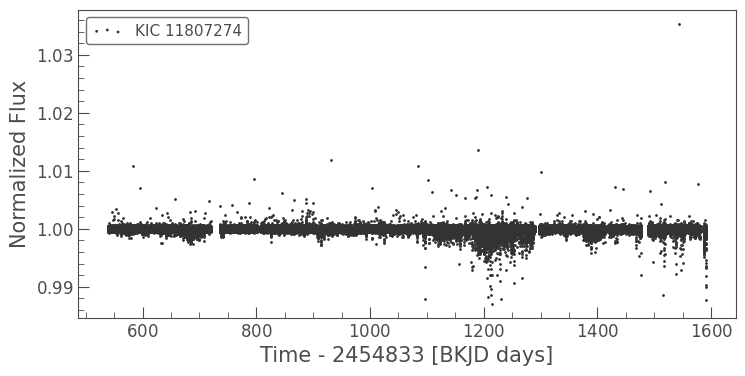

In [126]:
lightcurve = all_lightcurves.stitch(lambda x: x.remove_nans().normalize().flatten()).remove_nans().flatten()
lightcurve.scatter()

In [127]:
raw_fluxes = lightcurve['flux'].unmasked.value
raw_fluxes = raw_fluxes[~np.isnan(raw_fluxes)]

times = lightcurve['time'].value
data = list(zip(times, raw_fluxes))
data = sorted(data, key=lambda x:x[0])
times, raw_fluxes = zip(*data)


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

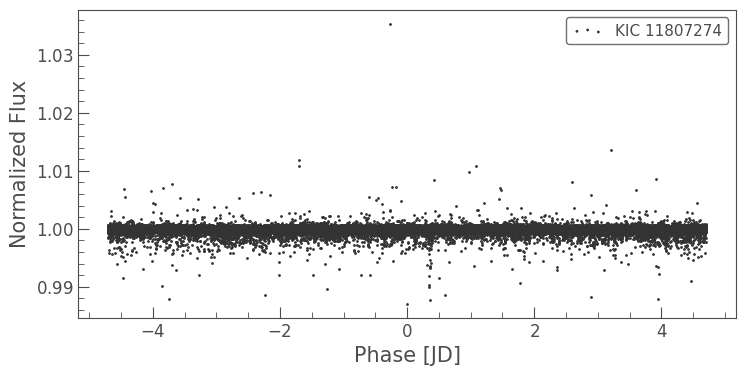

In [131]:
# actual_tp = 2.18053539
actual_tp = 9.4
actual_folded = lightcurve.fold(period=actual_tp, epoch_time=times[np.where(raw_fluxes==min(raw_fluxes))[0][0]])
actual_folded.scatter()

(<Figure size 1120x1120 with 1 Axes>, <Axes: >)

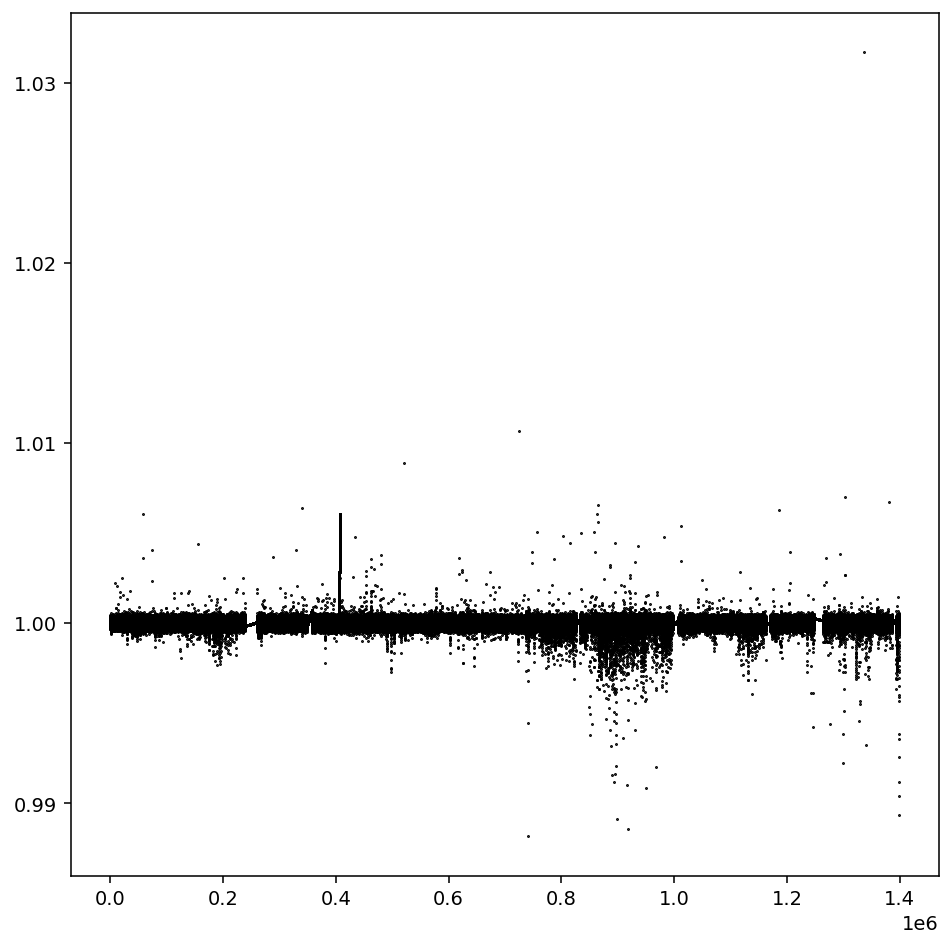

In [132]:
period = get_period(times)

interpolating_x = np.arange(np.ceil(times[0]), times[-1], period)
f = interp1d(x=times, y=raw_fluxes, kind='linear')

interpold = f(interpolating_x)

new_x = interpolating_x - interpolating_x[0]
# reformat x to have spacing of 1.0: this allows for signal processing further down.

reformatting_factor = get_period(new_x)

new_x = new_x / reformatting_factor

plot_ts(new_x, interpold)

(<Figure size 1120x1120 with 1 Axes>, <Axes: >)

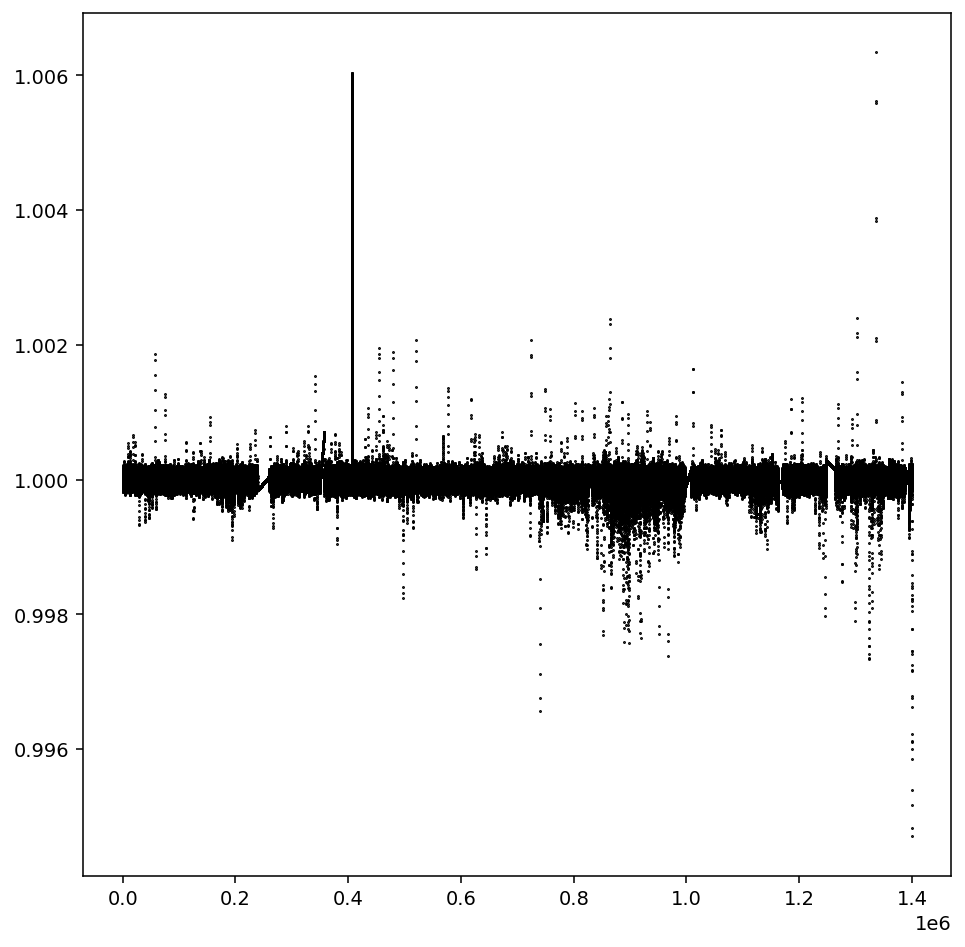

In [133]:
smooth_1 = ndimage.gaussian_filter1d(interpold, sigma=2)
plot_ts(new_x, smooth_1)

(<Figure size 1120x1120 with 1 Axes>, <Axes: >)

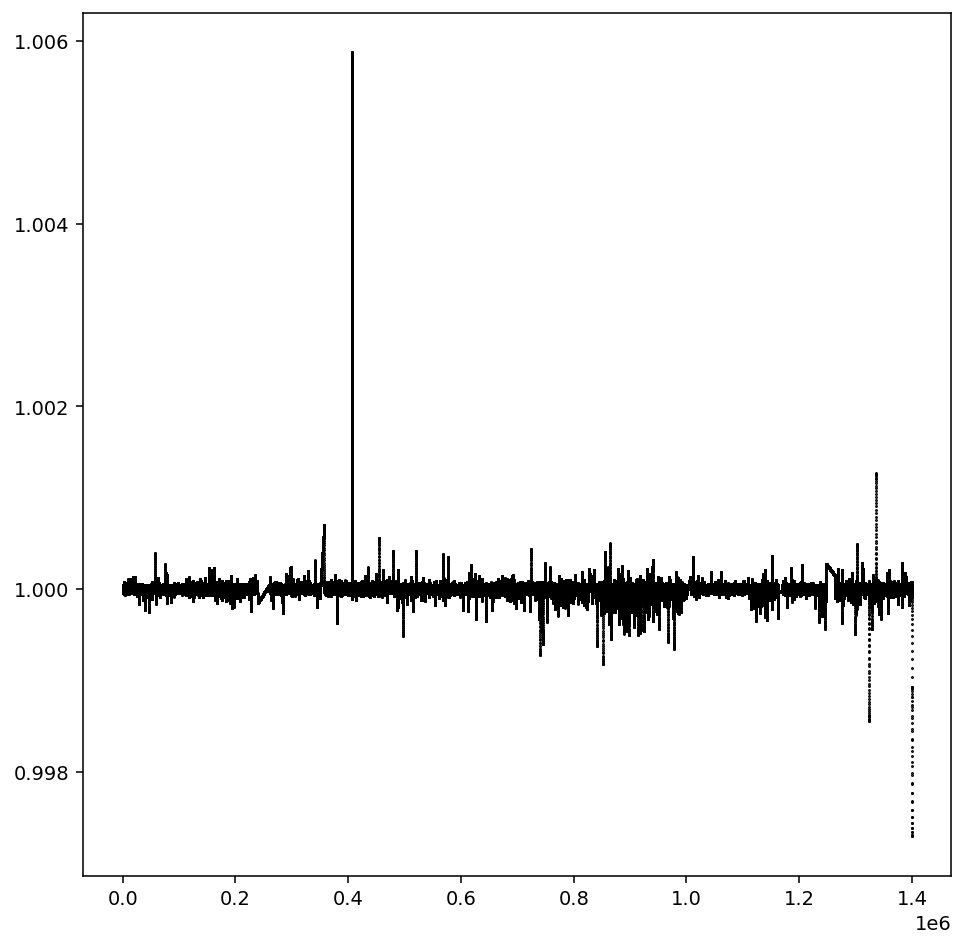

In [134]:
smooth_2 = ndimage.gaussian_filter1d(interpold, sigma=10)
plot_ts(new_x, smooth_2)

(<Figure size 1120x1120 with 1 Axes>, <Axes: >)

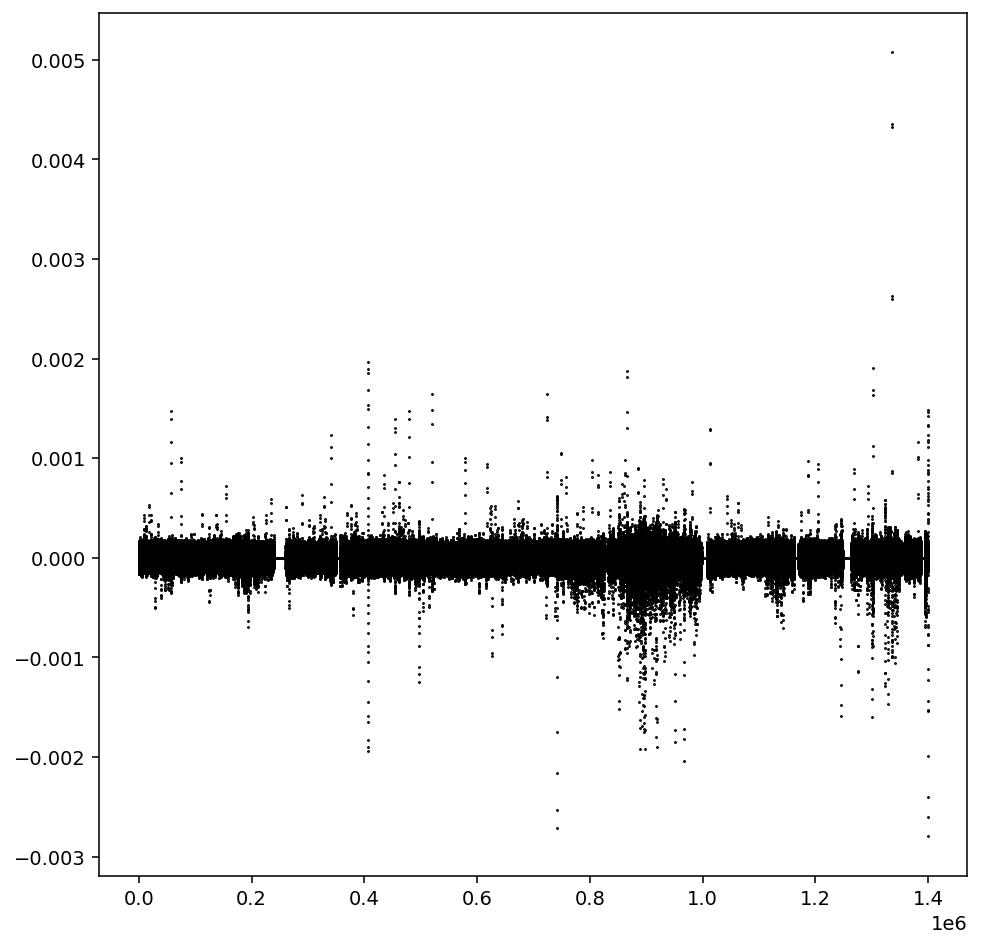

In [135]:
flattened = smooth_1-smooth_2
plot_ts(new_x, flattened)

(<Figure size 1120x1120 with 1 Axes>, <Axes: >)

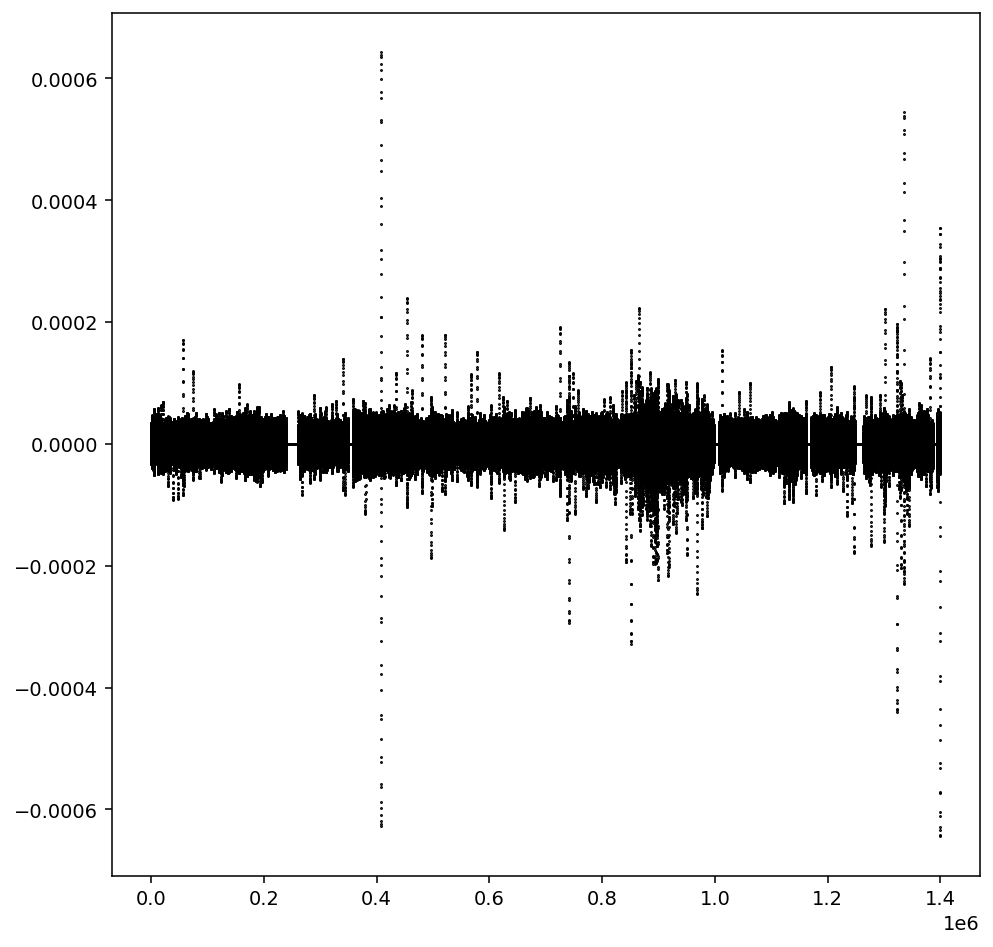

In [136]:
smooth_3 = ndimage.gaussian_filter1d(flattened, sigma=8)
plot_ts(new_x, smooth_3)

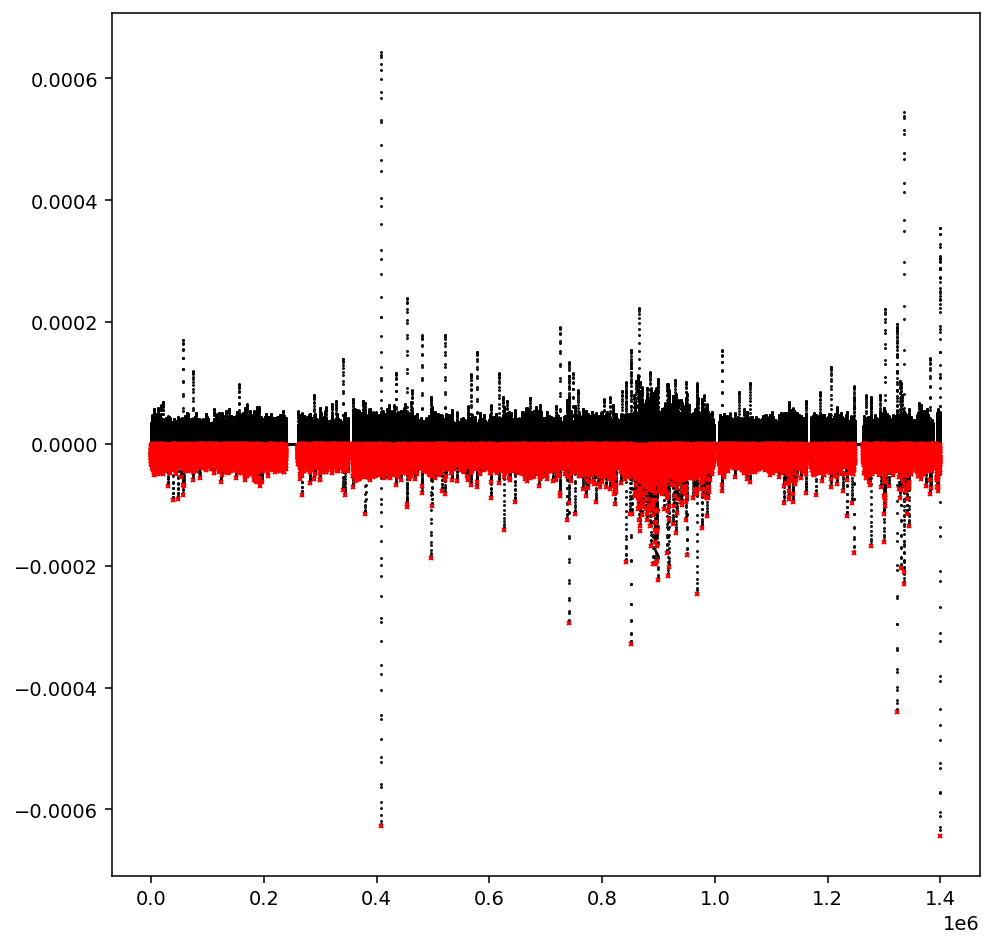

In [137]:
# -ve because we want the troughs, not peaks
peaks, properties = find_peaks(smooth_3*-1, height=0)
fig, ax = plt.subplots()
ax.plot(new_x, smooth_3, 'k.', markersize=1)
ax.plot(peaks, smooth_3[peaks], 'rx', markersize=2)
ave = average(smooth_3)

# ax.plot([new_x[0], new_x[-1]], [ave,ave])

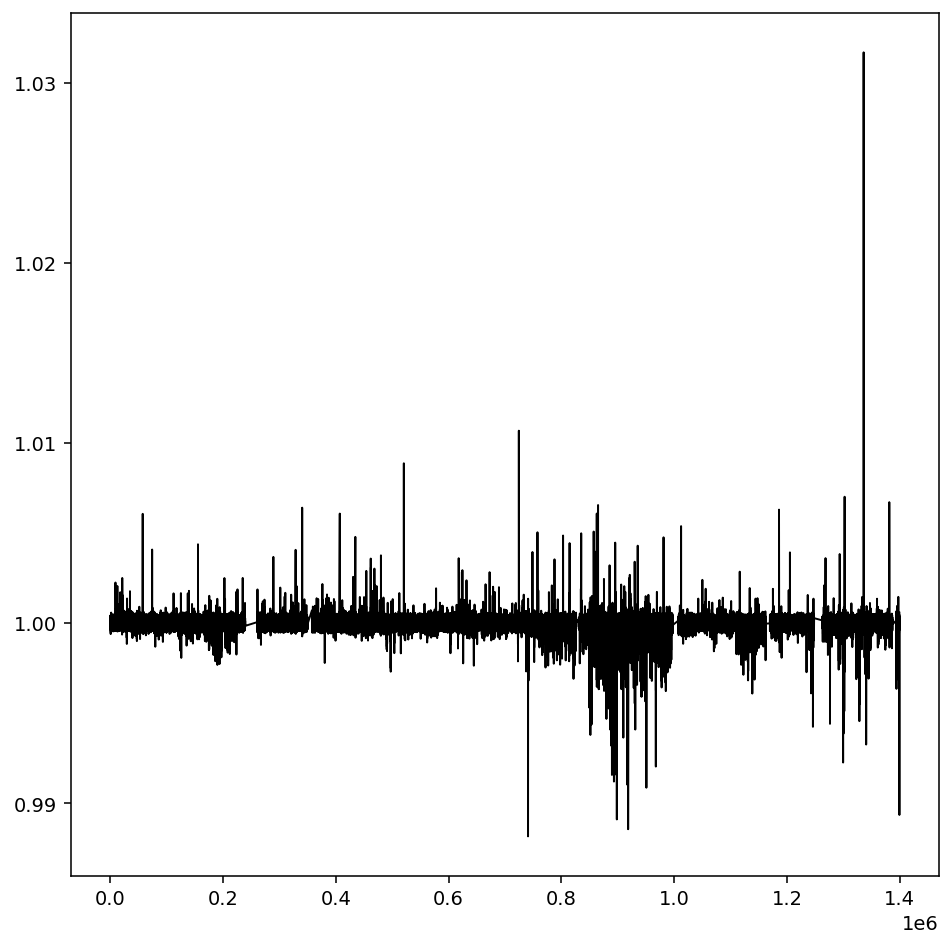

In [138]:
# -ve because we want the troughs, not peaks
peaks, properties = find_peaks(interpold*-1, plateau_size=3)
fig, ax = plt.subplots()
ax.plot(new_x, interpold, 'k-', linewidth=1)
ax.plot(peaks, interpold[peaks], 'rx', markersize=2)
# ave = average(smooth_3)
# ax.plot([new_x[0], new_x[-1]], [ave,ave])

(<Figure size 1120x1120 with 1 Axes>, <Axes: >)

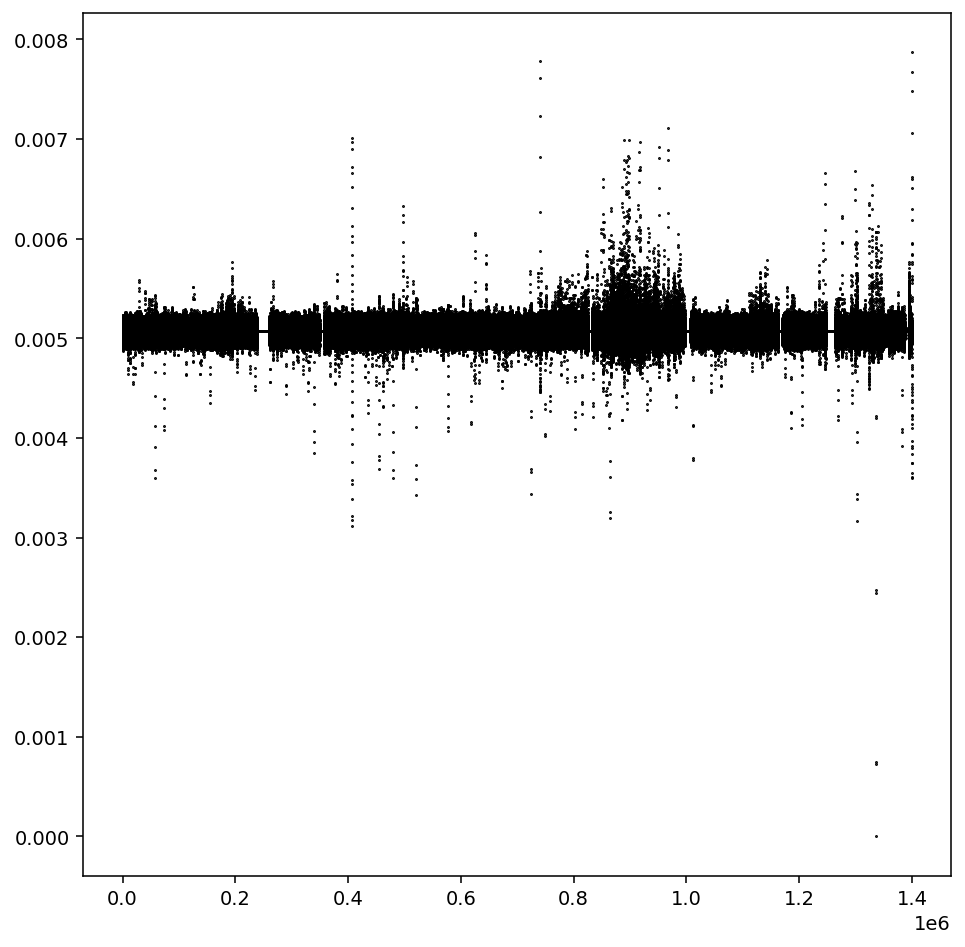

In [139]:
flattened_ptve = (flattened*-1) + abs(max(flattened))
plot_ts(new_x, flattened_ptve)

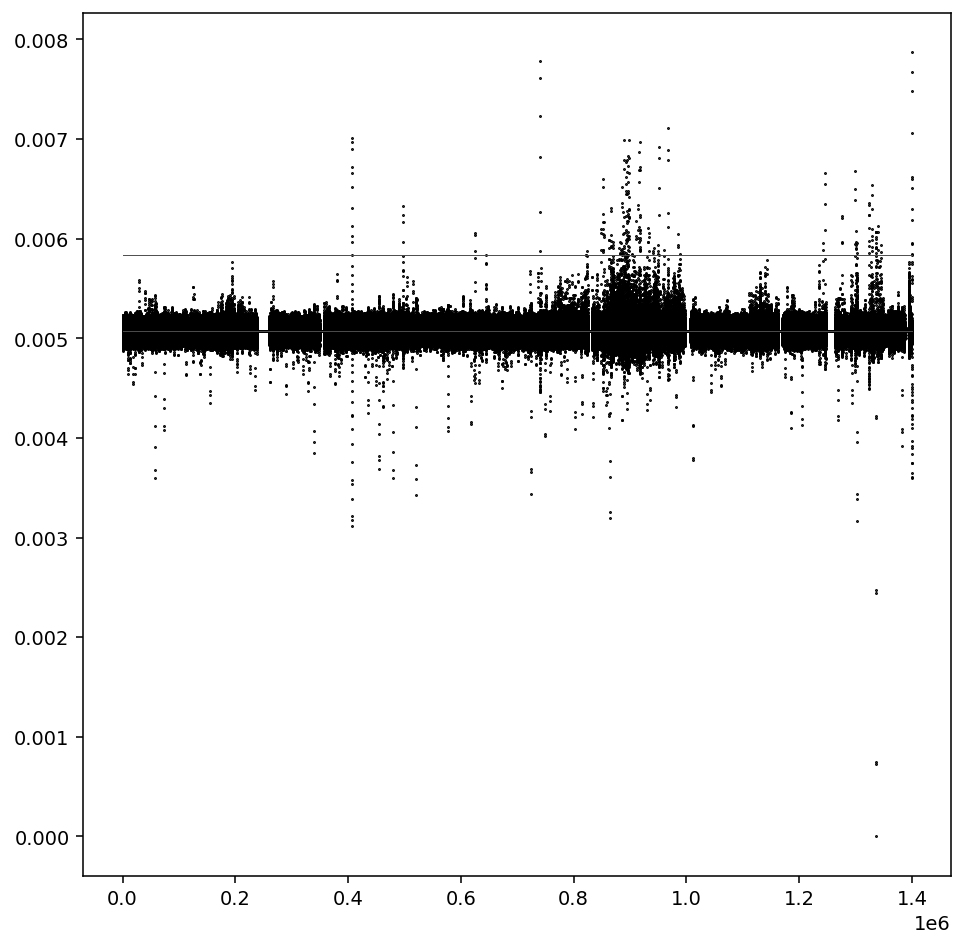

In [144]:
ave = average(flattened_ptve)
fig, ax = plot_ts(new_x, flattened_ptve)
ax.plot([new_x[0], new_x[-1]],[ave,ave], 'r-', linewidth=0.5)
percent = 0.15
ax.plot([new_x[0], new_x[-1]],[ave*(1+percent),ave*(1+percent)], 'r-', linewidth=0.5)

threshold = ave * percent

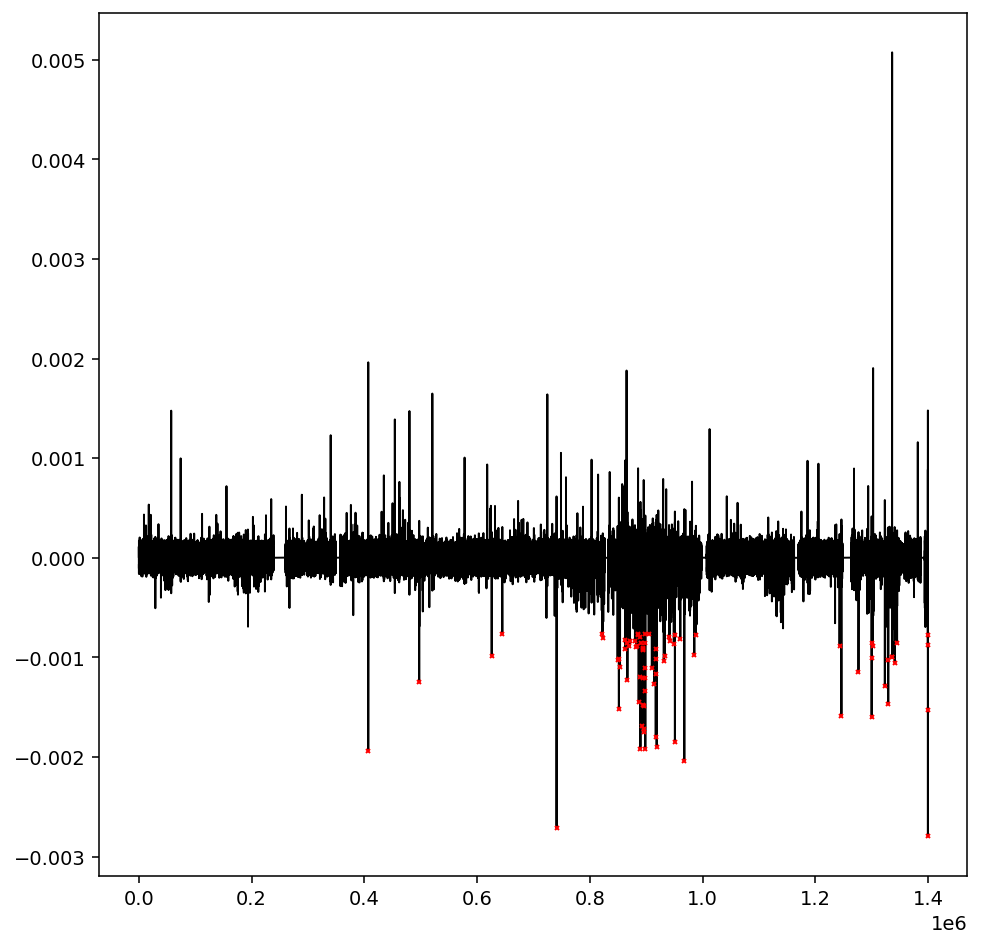

In [145]:
# -ve because we want the troughs, not peaks
peaks, properties = find_peaks(flattened*-1, height=threshold)
fig, ax = plt.subplots()
ax.plot(new_x, flattened, 'k-', linewidth=1)
ax.plot(peaks, flattened[peaks], 'rx', markersize=2)

epoch_time = interpolating_x[np.where(flattened==flattened[peaks][len(peaks)//2])[0]][0]

In [ ]:
signal = [-1*flattened[i] if i in peaks else 0 for i in range(len(new_x))]
fig,ax=plt.subplots()
width = (interpolating_x[-1] - interpolating_x[0]) / len(interpolating_x)
ax.bar(interpolating_x,signal,width=0.1)

first = interpolating_x[np.where(signal == max(signal))[0]][0]
real_transits = np.arange(first, max(interpolating_x), 2.18)
transits_y=[0.001]*len(real_transits)
ax.plot(real_transits, transits_y, 'kx', markersize=1)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ff675240f70> (for post_execute):


KeyboardInterrupt: 

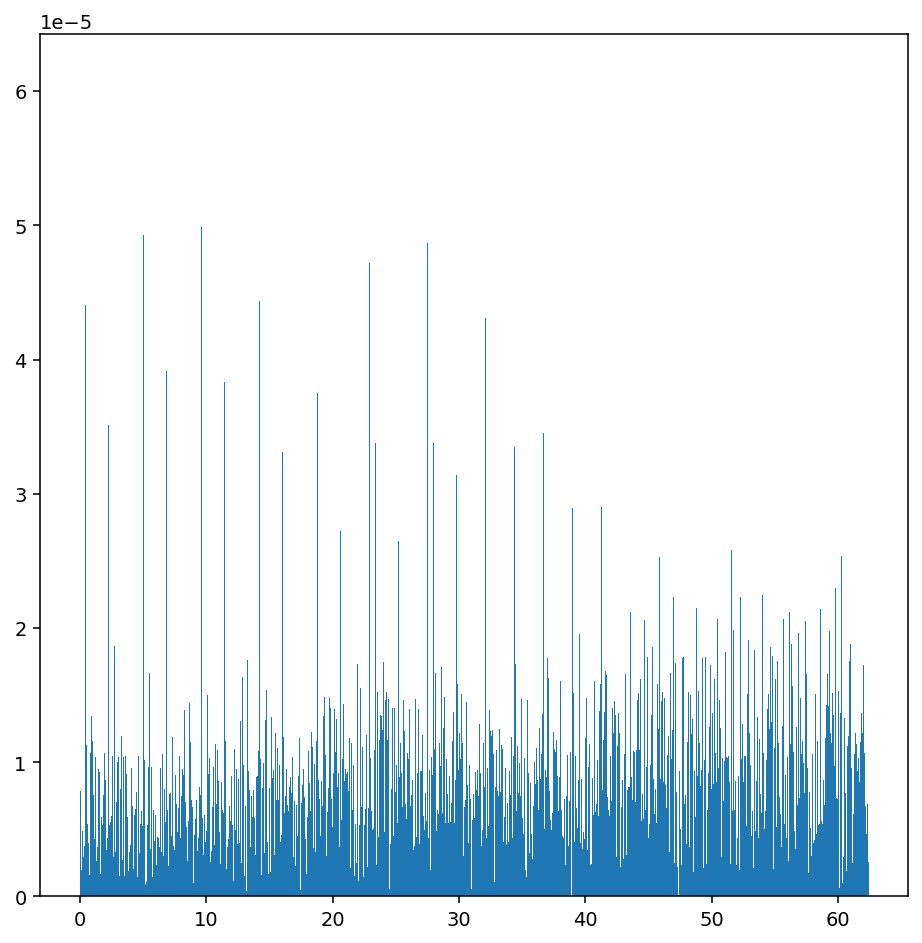

In [32]:
freq, trans = perform_fft(interpolating_x, signal, plottimeseries=False, plotfrequencies=True, removezerofreq=True)

In [34]:
# peaks, properties = find_peaks(trans, height=0.01)

# prominence_data = peak_prominences(trans,peaks)
# prominences=prominence_data[0]
# bases = prominence_data[1]
# sorted_prominences = list(sorted(prominences, reverse=True))

# # prominence_threshold = sorted_prominences[len(sorted_prominences)//10]
# prominence_threshold = sorted_prominences[len(sorted_prominences)//4]

# best_prominences_indexes = np.where(prominences>prominence_threshold)

# best_peaks = peaks[best_prominences_indexes]

# signalinception = [trans[i] if i in best_peaks else 0 for i in range(len(freq))]

# combined = [(signalinception[i], freq[i]) for i in range(len(signalinception)) if signalinception[i] > 0]

# signalinception = [sum([s*np.sin(i*f*2*np.pi) for s,f in combined]) for i in range(len(interpolating_x))]

# fig, ax = plt.subplots()
# ax.plot(interpolating_x, signalinception)
# actual_ts_x = np.arange(interpolating_x[0], interpolating_x[-1], 2.18)
# ax.plot(actual_ts_x, [0]*len(actual_ts_x), 'kx', markersize=2)


# freqinception, transinception = perform_fft(interpolating_x, signalinception, plottimeseries=True,
#                                             plotfrequencies=True, removezerofreq=True)


0.4587155963302752


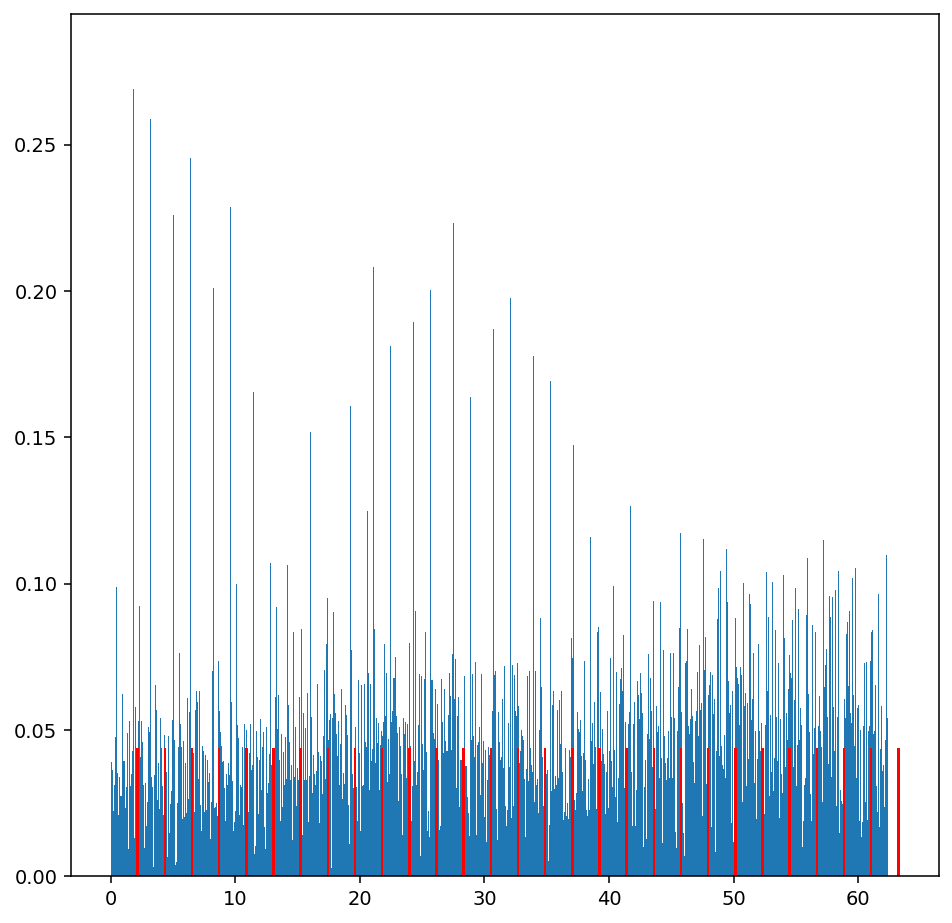

In [35]:
actual_tp = 2.18
actual_freq = 1/2.18
print(actual_freq)

fig, ax = plt.subplots()
width = (freq[-1] - freq[0]) / len(freq)
ax.bar(freq, trans, width=width*1.5)
for i in range(1,30):
    ax.bar([i/actual_freq], [average(trans)], width=0.2, color='r')

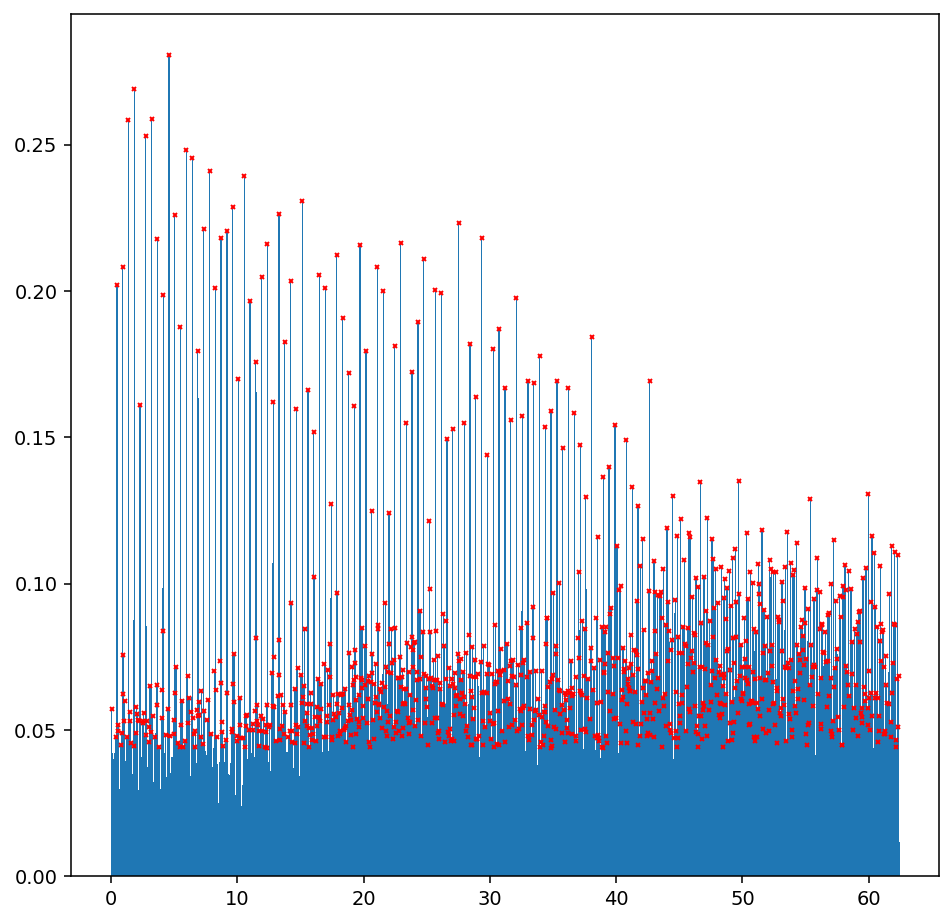

In [36]:
freq_spacing = get_period(freq)

peaks, properties = find_peaks(trans, height=average(trans))

fig, ax = plt.subplots()
ax.bar(freq, trans, width=0.1)
ax.plot(peaks*freq_spacing, trans[peaks], 'rx', markersize=2)

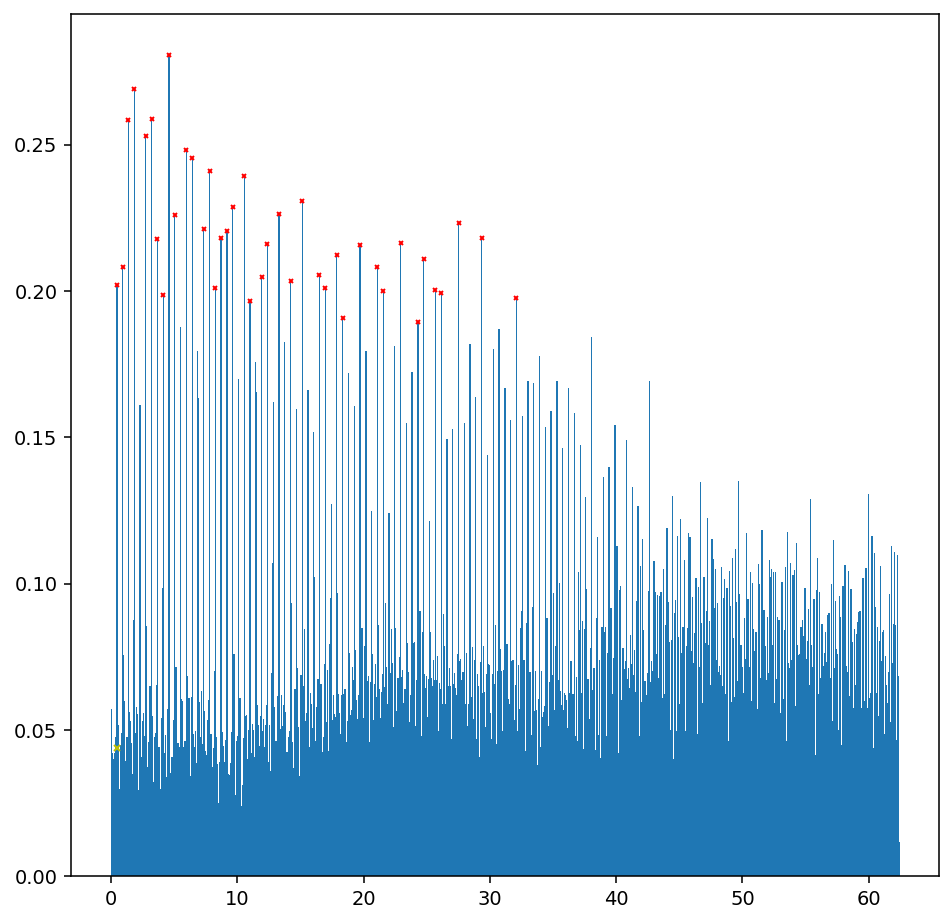

In [52]:
peaks, properties = find_peaks(trans, height=0.01)

prominence_data = peak_prominences(trans,peaks)
prominences=prominence_data[0]
bases = prominence_data[1]
sorted_prominences = list(sorted(prominences, reverse=True))

# prominence_threshold = sorted_prominences[len(sorted_prominences)//6]
prominence_threshold = sorted_prominences[40]

best_prominences_indexes = np.where(prominences>prominence_threshold)

best_peaks = peaks[best_prominences_indexes]

fig, ax = plt.subplots()
ax.bar(freq, trans, width=0.1)
ax.plot(best_peaks*freq_spacing, trans[best_peaks], 'rx', markersize=2)
ax.plot(actual_freq, average(trans), 'yx', markersize=3)

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

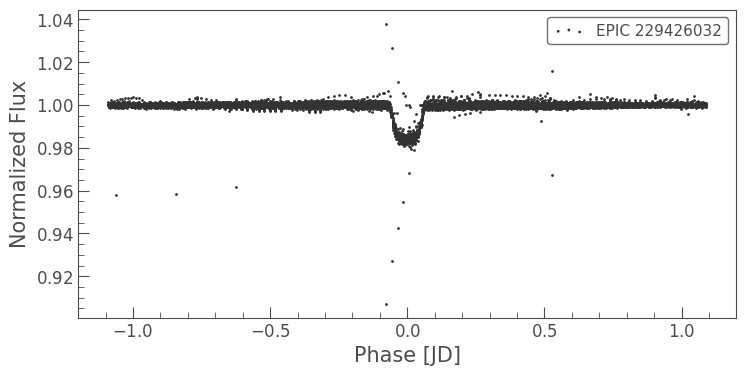

In [53]:
actual_tp = 2.18053539
actual_folded = lightcurve.fold(period=actual_tp, epoch_time=epoch_time)
actual_folded.scatter()



/usr/local/lib/python3.10/dist-packages/lightkurve/lightcurve.py:1956: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)


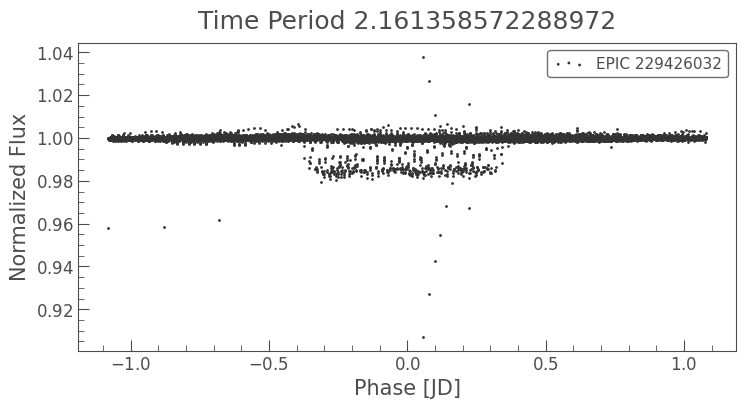

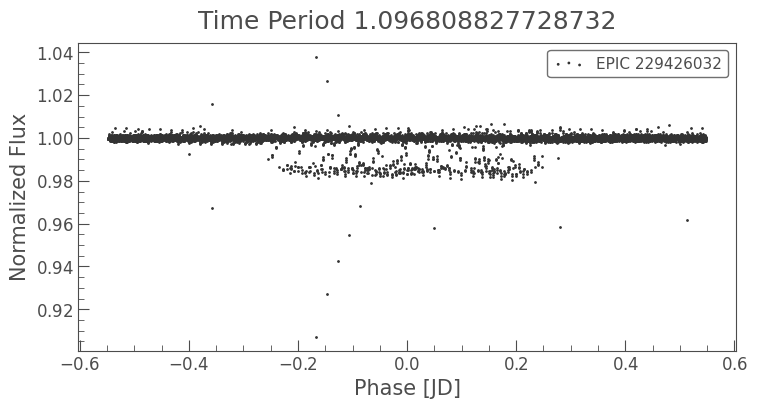

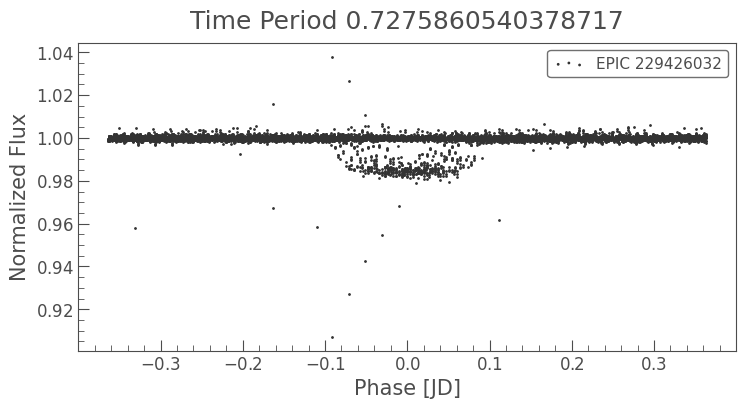

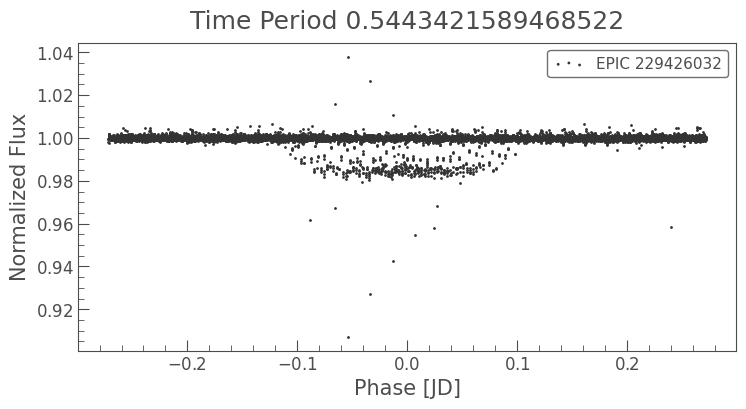

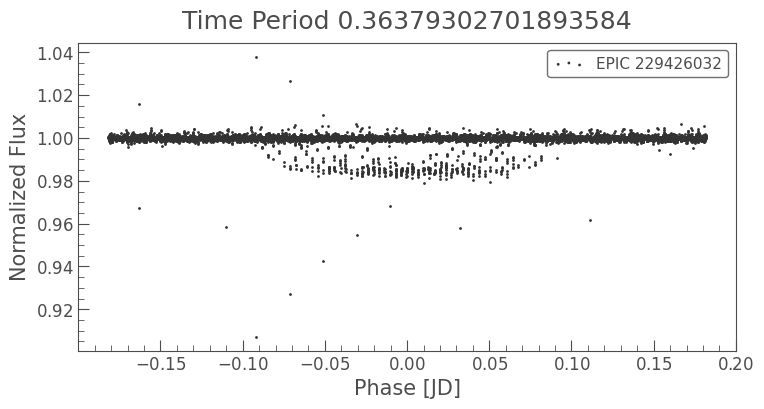

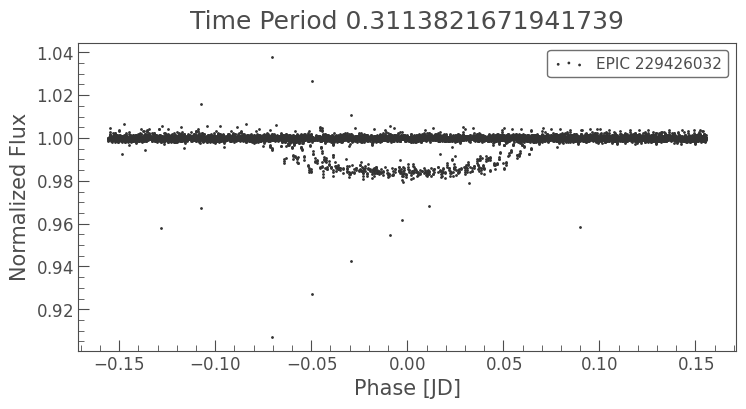

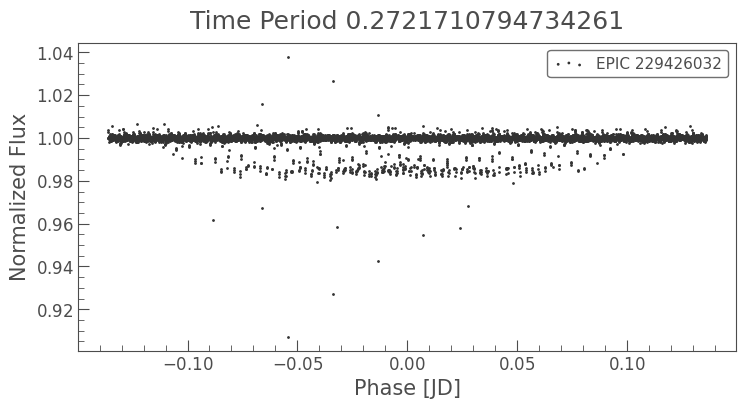

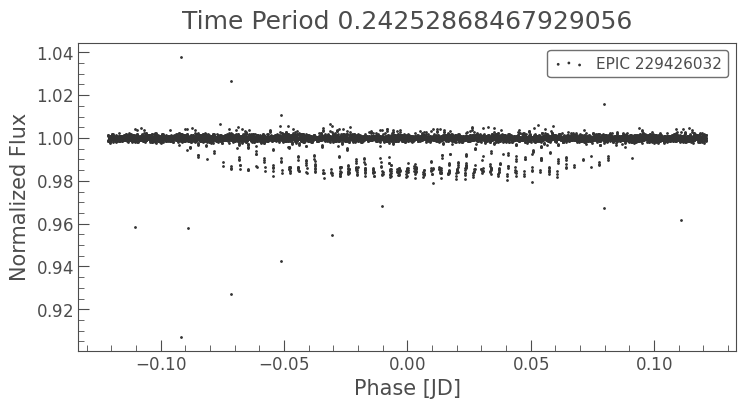

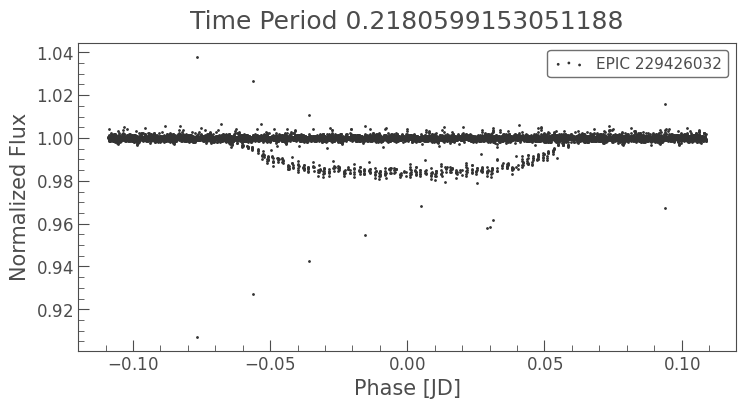

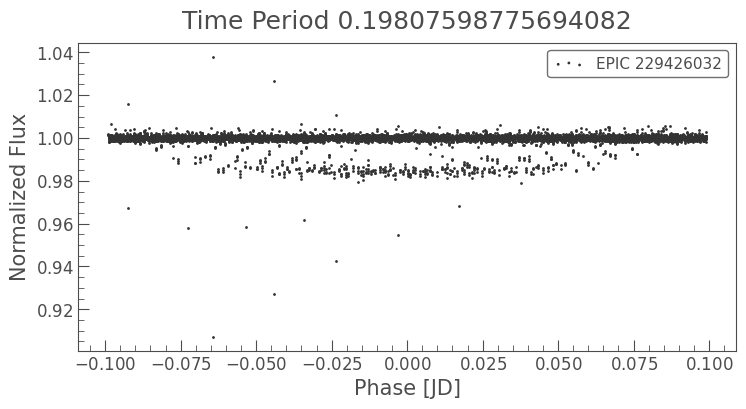

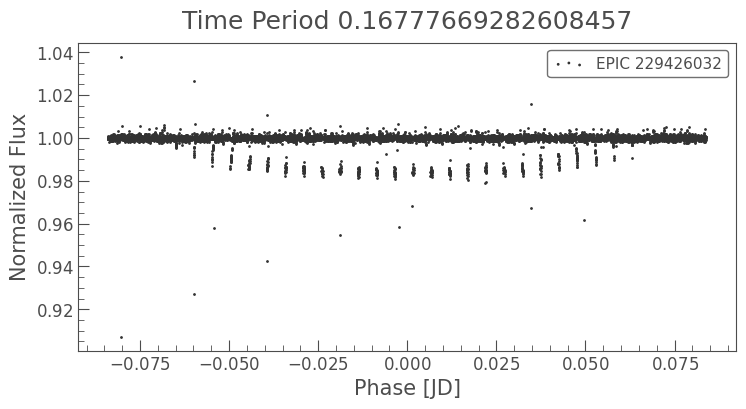

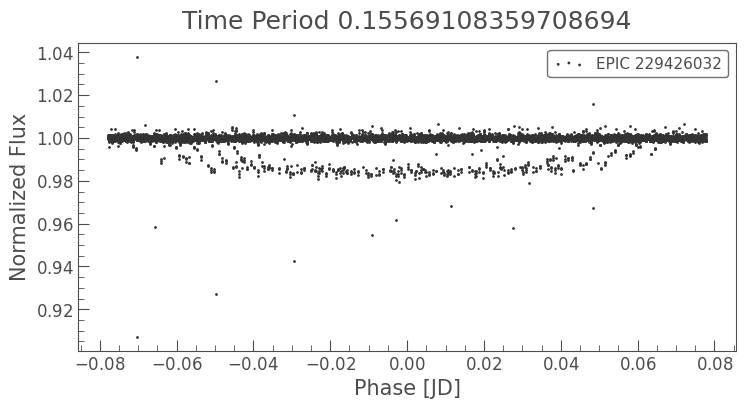

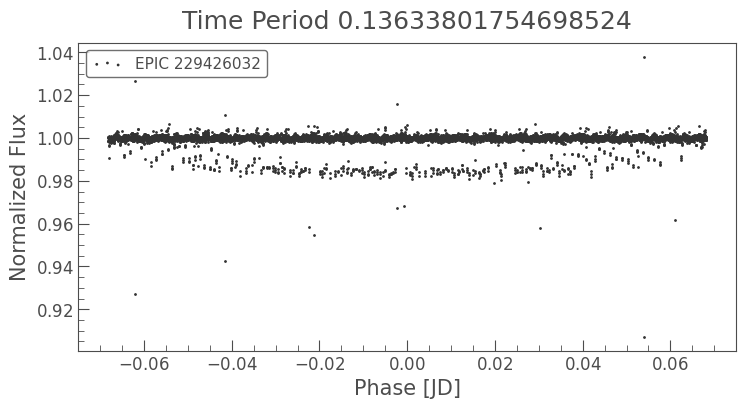

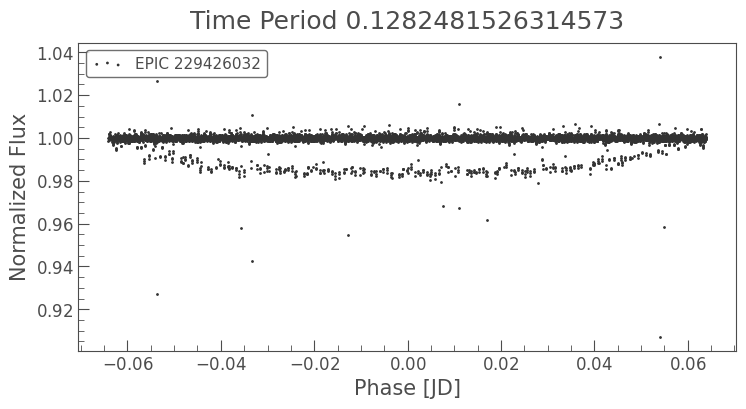

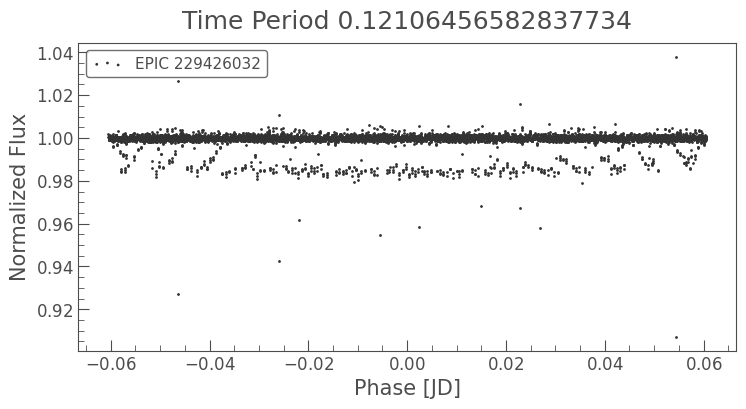

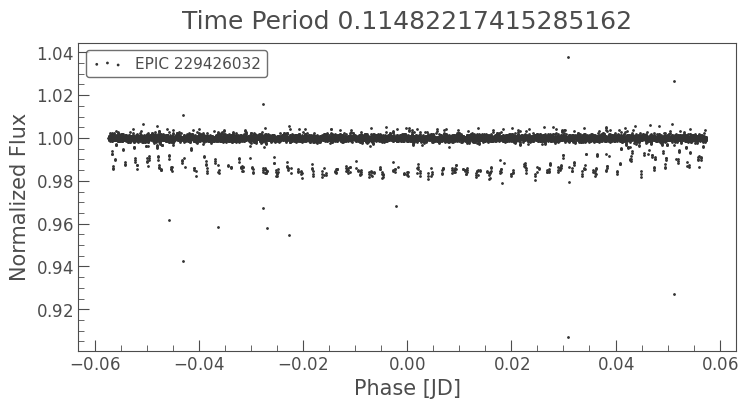

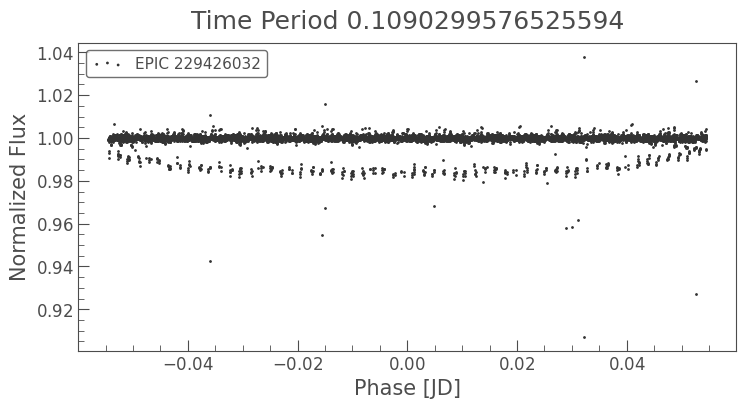

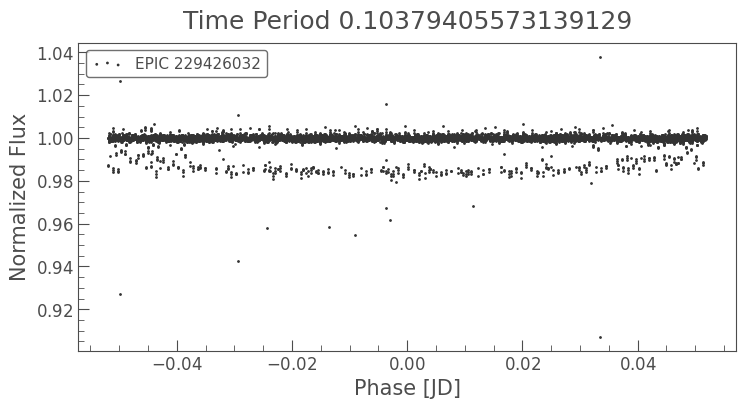

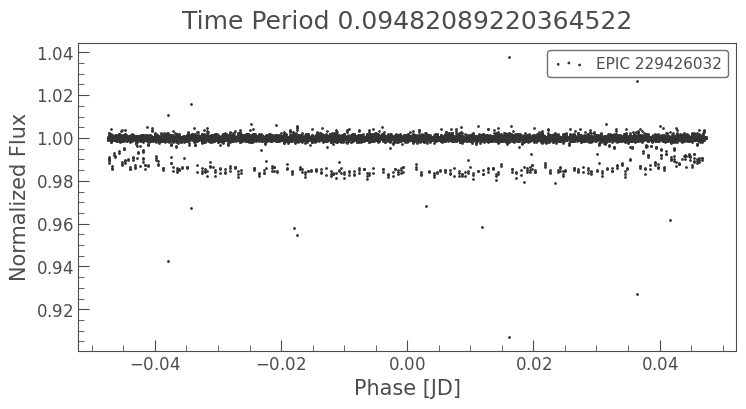

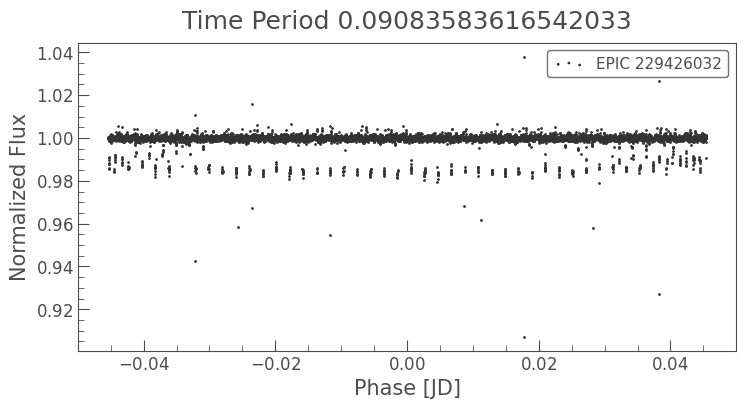

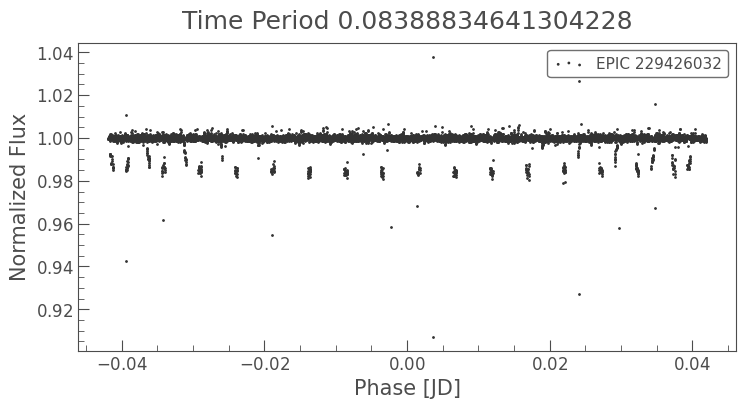

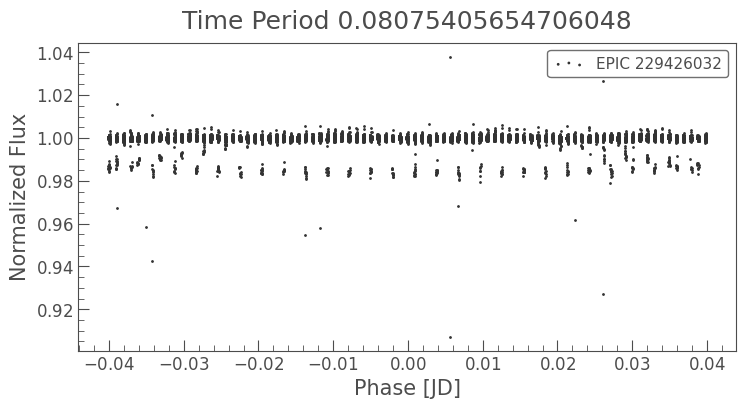

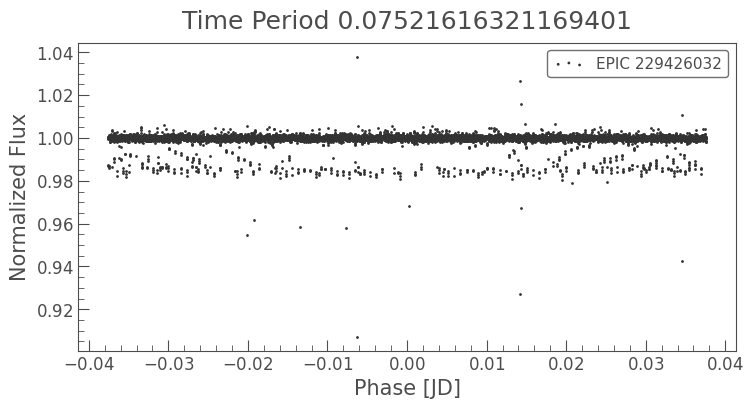

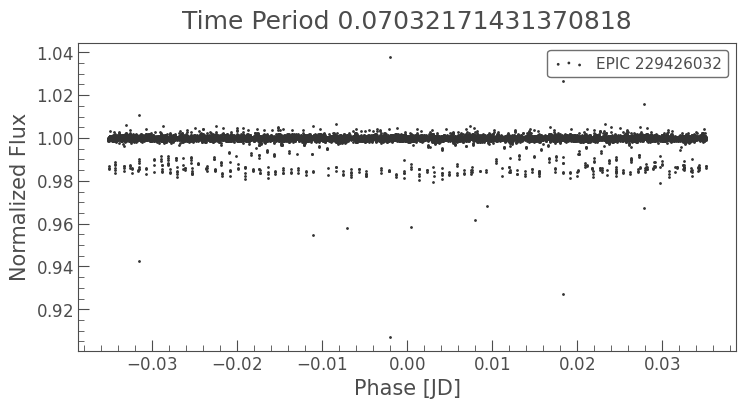

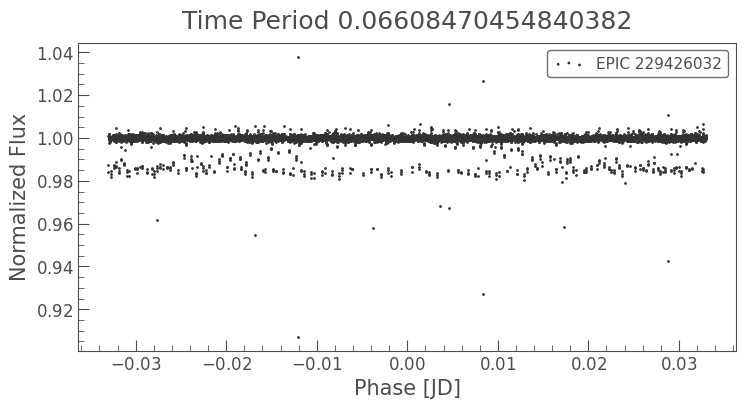

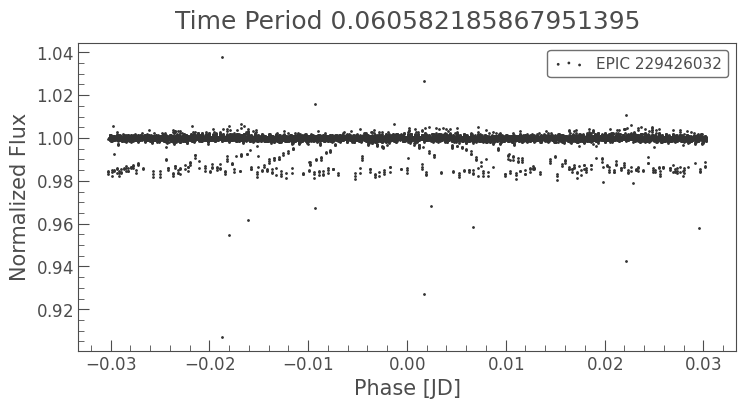

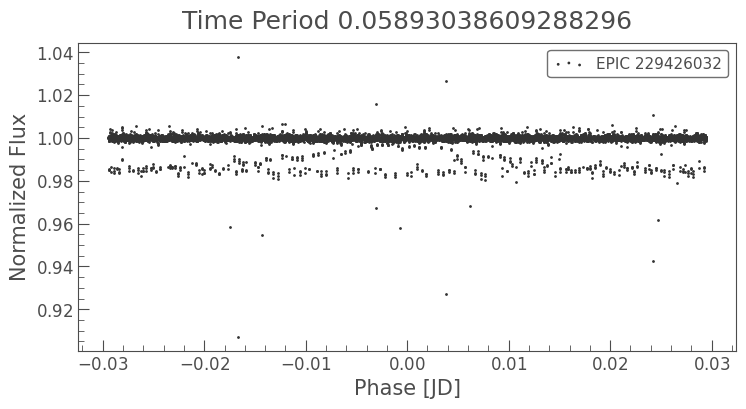

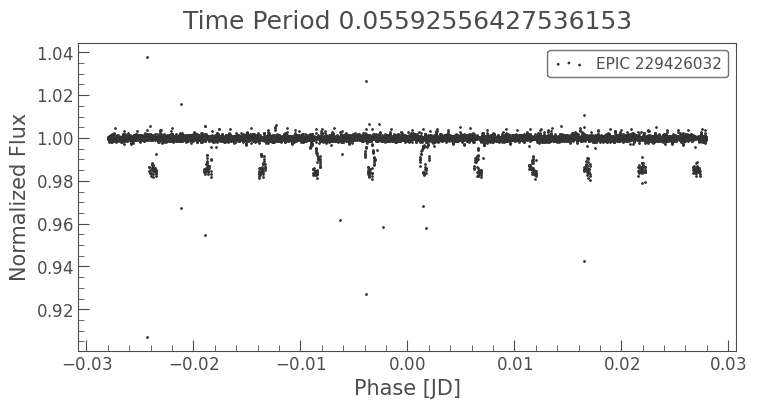

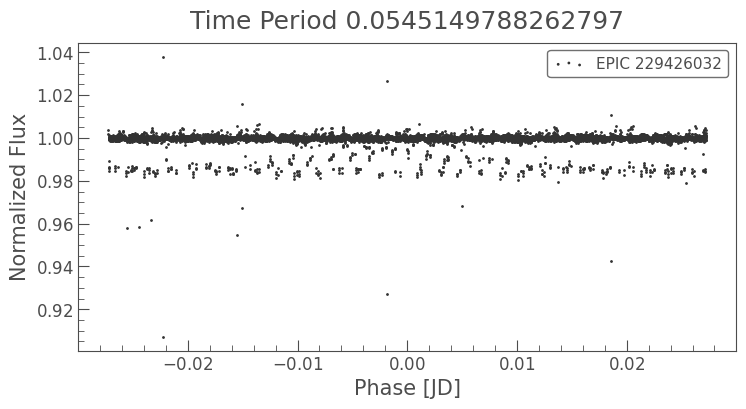

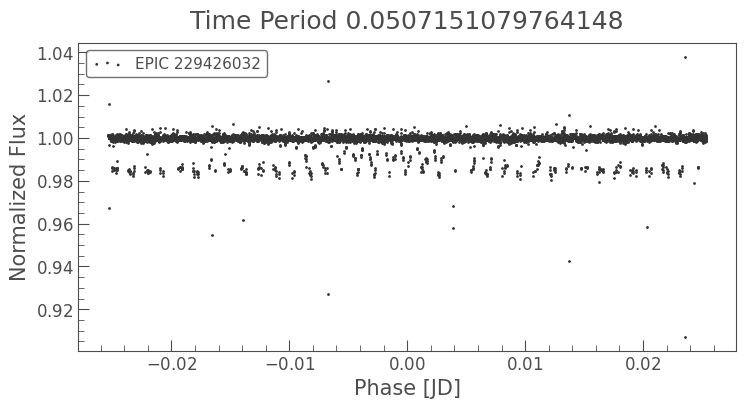

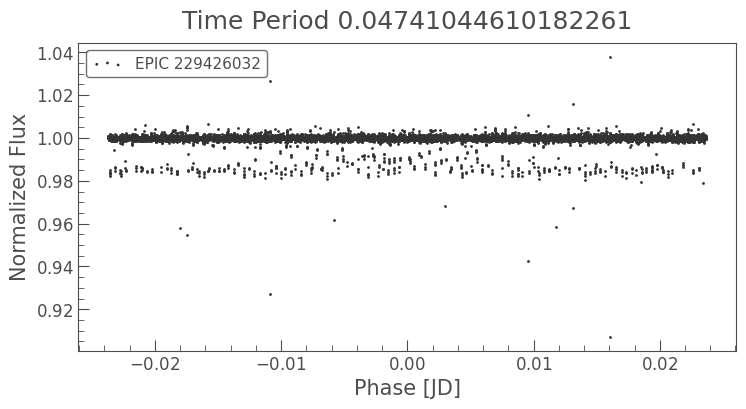

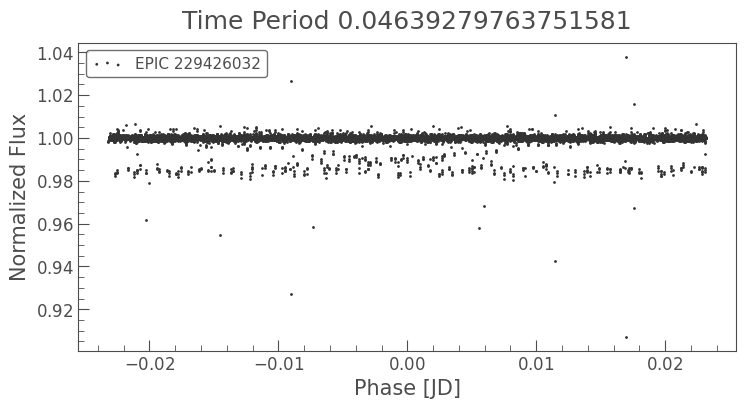

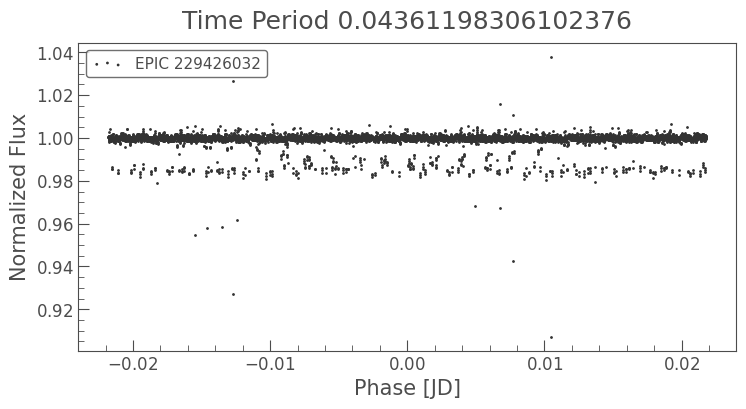

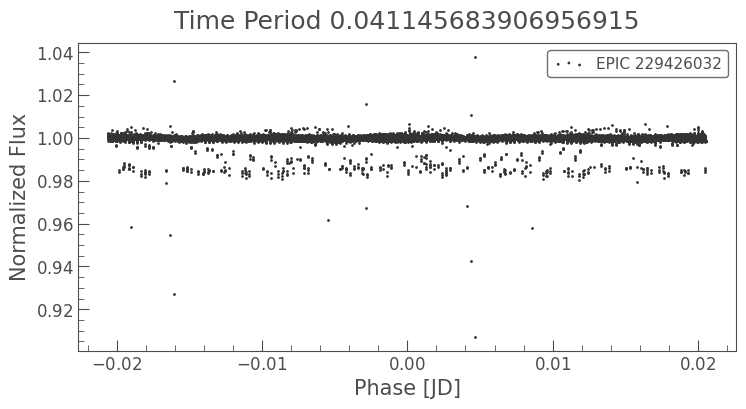

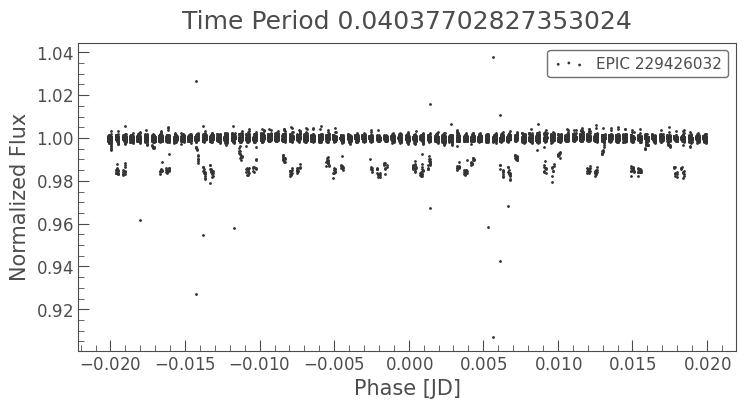

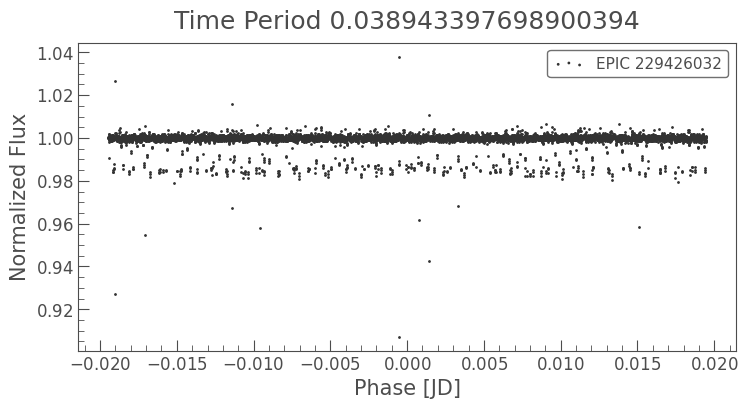

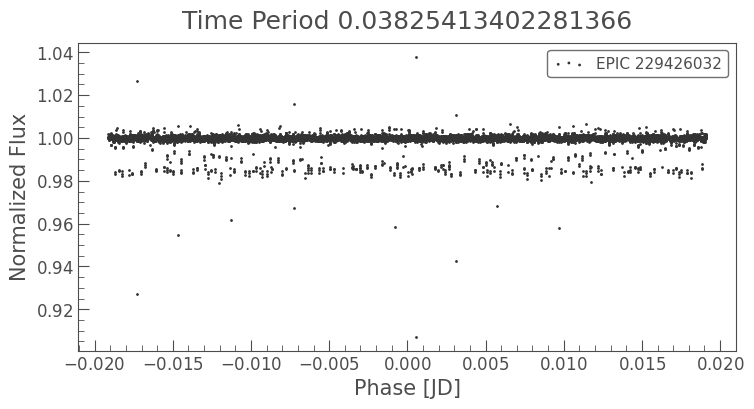

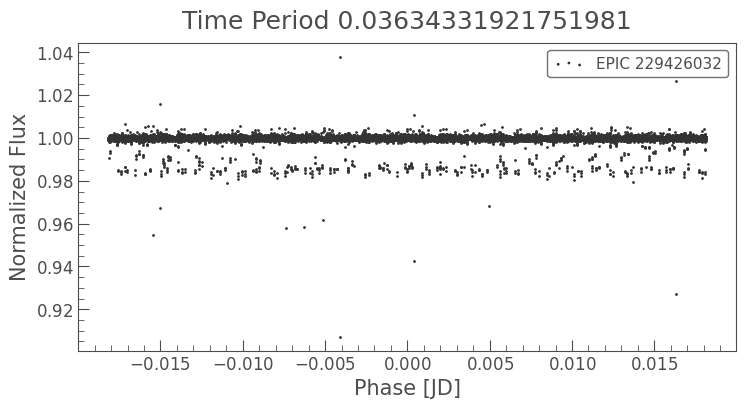

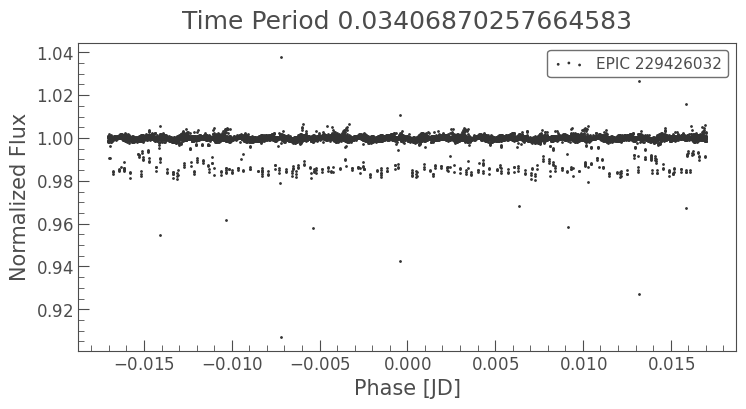

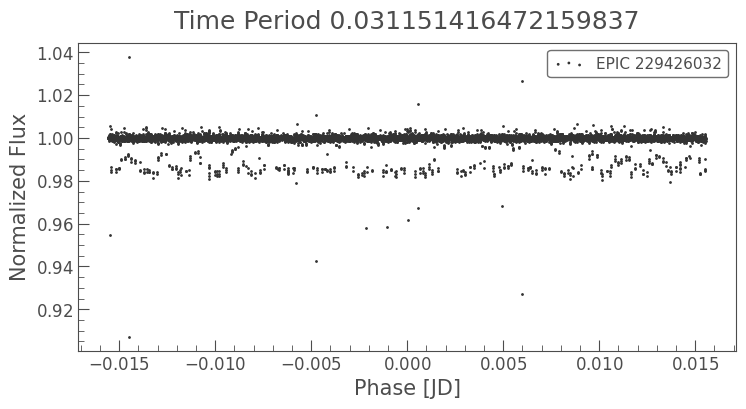

In [54]:
for peak in best_peaks:
    peak_frequency = freq[peak]
    tp = 1/peak_frequency
    folded = lightcurve.fold(period=tp, epoch_time=epoch_time)
    ax = folded.scatter()
    ax.title.set_text(f"Time Period {tp}")

In [55]:
detected_freq = freq[best_peaks[0]]
detected_tp = 1/detected_freq
detected_tp

2.161358572288972

In [70]:
def get_curve(x, radius_ratio, ldc1, ldc2, t0, time_period, orbital_radius, orbital_inclination):
    tm = QuadraticModel()
    tm.set_data(x)
#     r_star = 1.261 * constants.R_sun.value
    return tm.evaluate(k=radius_ratio,
                       ldc=[ldc1,ldc2],
                       t0=t0,
                       p=time_period,
                       a=orbital_radius,
                       i=orbital_inclination)


[ 1.10253211e-01  1.18458341e-06  1.50011771e+00 -2.11967737e-03
  2.18055722e+00  4.95152746e+00  1.46661189e+00]


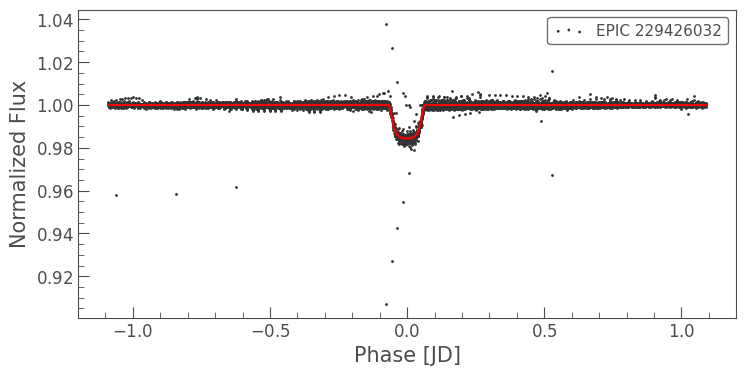

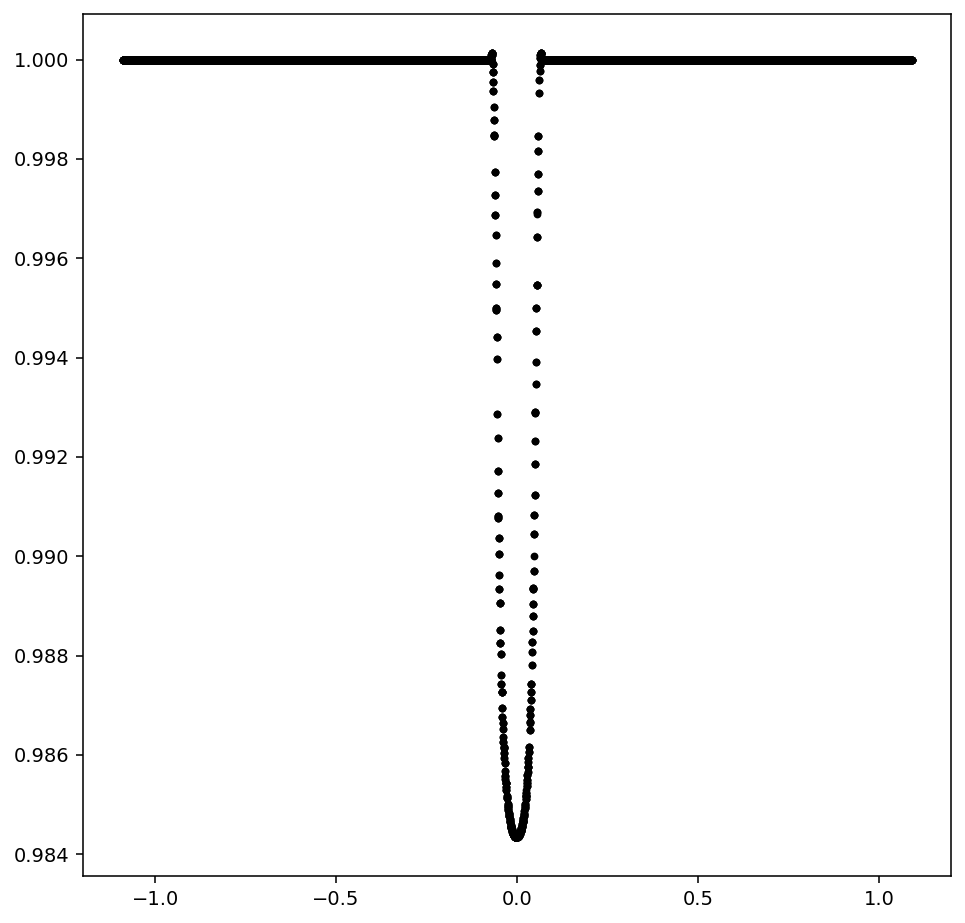

In [71]:
# raw = search_result[:3].download_all().stitch().remove_nans()

folded = lightcurve.fold(period=actual_tp, epoch_time=epoch_time)
ax = folded.scatter()

folded_times = folded['time'].value
folded_fluxes = folded['flux'].value
folded_err = folded['flux_err'].value

actual_tp = 2.1805577
popt, pcov = curve_fit(f=get_curve, xdata=folded_times, ydata=folded_fluxes,
                       p0=[0.1, 0.2, 0.1, 0.0, actual_tp, 3, 0.5*np.pi],
                       bounds=([0,0,0,min(folded_times),actual_tp-0.000001,0,0],
                               [1,np.inf,np.inf,max(folded_times),actual_tp,np.inf,np.pi*2]))

r_planet, ldc1, ldc2, t0, time_period, orbital_radius, orbital_inclination = popt

fitted_curve = get_curve(folded_times, r_planet, ldc1, ldc2, t0, time_period, orbital_radius, orbital_inclination)
ax.plot(folded_times, fitted_curve, 'r-')

print(popt)

fig,ax=plt.subplots()
ax.plot(folded_times,fitted_curve,'k.')

## TODO evaluate this using AI or some shit to fit params to folded curve then find var on that :DDD

In [ ]:
# temp_folded_times=np.linspace(folded_times[0],folded_times[-1],1000)


# tm = QuadraticModel()
# tm.set_data(temp_folded_times)
# #     r_star = 1.261 * constants.R_sun.value
# init_curve = tm.evaluate(k=0.1,
#                    ldc=[0.2,0.1],
#                    t0=0.0,
#                    p=2.18,
#                    a=3,
#                    i=0.5*np.pi)

# # init_curve = get_curve(temp_folded_times,0.1, 0.2, 0.1, 0.0, 2.18, 0.03, 0.5*np.pi)
# fig,ax=plt.subplots()
# ax.plot(temp_folded_times,init_curve,'k.')

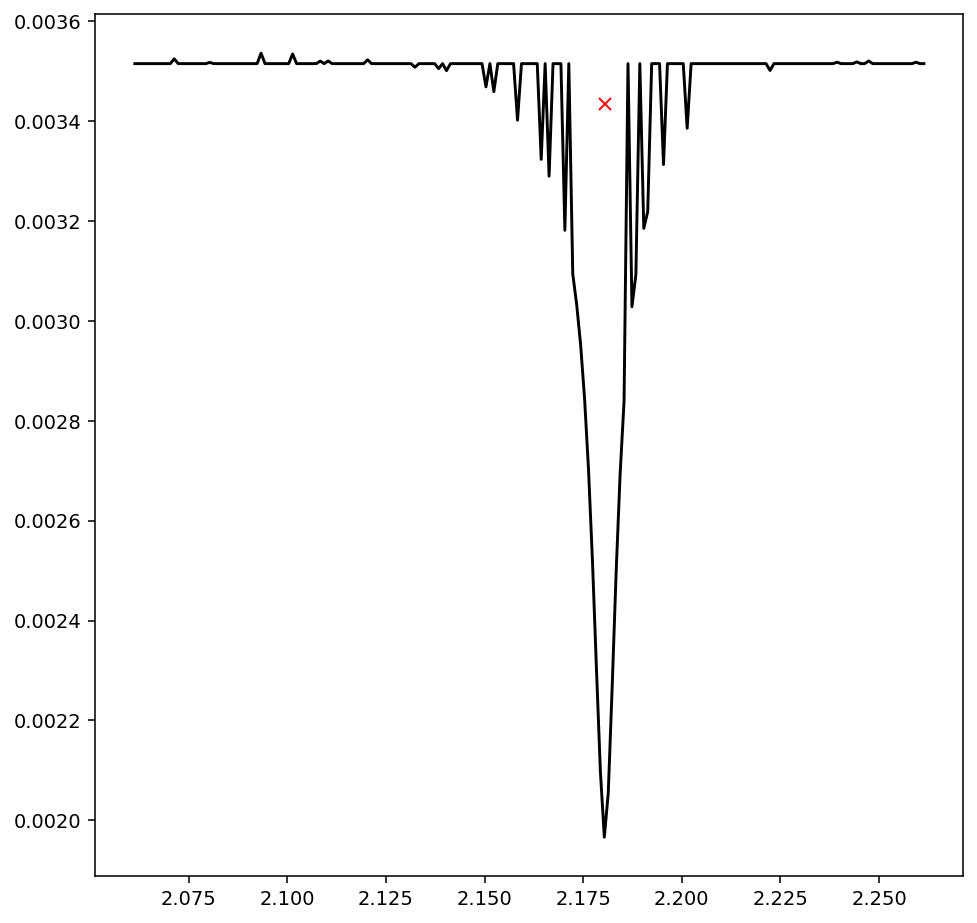

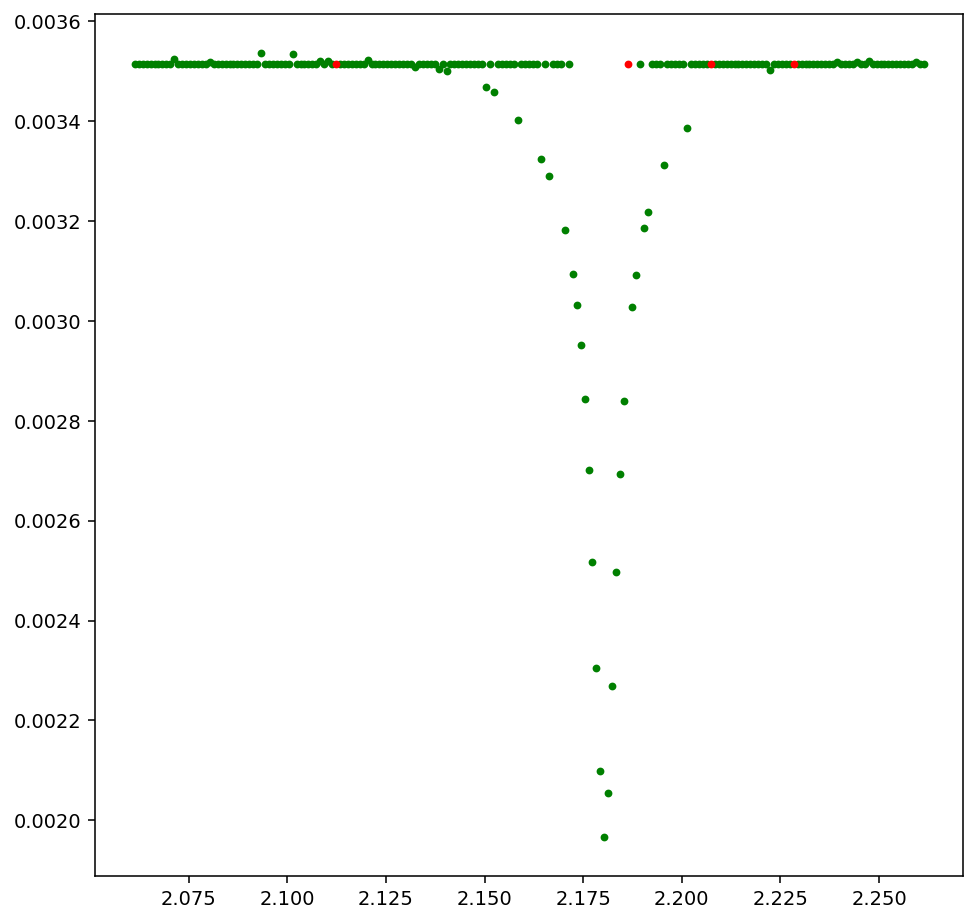

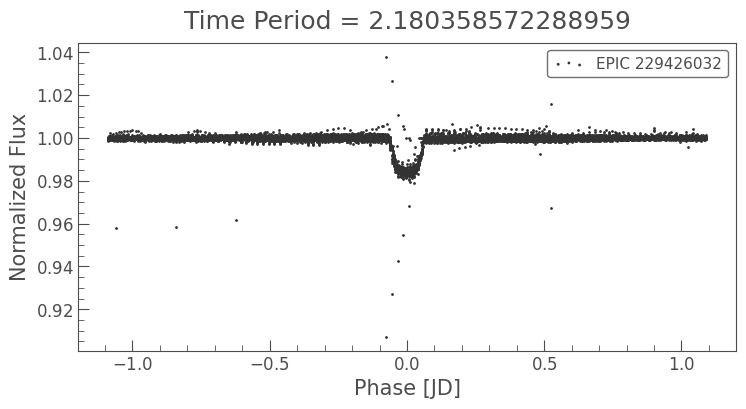

In [72]:
possibles = np.arange(detected_tp-0.1, detected_tp+0.1, 0.001)
variances=[]
fitted_ones = []
unfitted_ones = []
for possible_tp in possibles:
    folded = lightcurve.fold(period=possible_tp, epoch_time=epoch_time)
    folded_fluxes = folded['flux'].value
    folded_times = folded['time'].value

#     folded_fluxes_average = moving_average_same_dimensions(folded_fluxes,n=3)
#     folded_fluxes_gauss = gaussian_smooth(folded_fluxes,sigma=3)

    is_fitted = False
    try:
        popt, pcov = curve_fit(f=get_curve, xdata=folded_times, ydata=folded_fluxes,
                               p0=[0.1, 0.2, 0.1, 0.0, possible_tp, 3, 0.5*np.pi],
                       bounds=([0,0,0,min(folded_times),possible_tp-0.000001,0,0],
                               [1,np.inf,np.inf,max(folded_times),possible_tp,np.inf,np.pi*2]))

        r_planet, ldc1, ldc2, t0, time_period, orbital_radius, orbital_inclination = popt

        fitted_curve = get_curve(folded_times, r_planet, ldc1, ldc2, t0, time_period,
                                 orbital_radius, orbital_inclination)
        is_fitted = True
    except:
        fitted_curve = np.zeros(len(folded_times))

    about_zero = folded_fluxes-fitted_curve
    var = np.std(about_zero)
    variances.append(var)
    if is_fitted:
        fitted_ones.append((possible_tp, var))
    else:
        unfitted_ones.append((possible_tp, var))

fig,ax=plt.subplots()
ax.plot(possibles, variances, 'k-')
# ax.vlines(x=actual_tp, ymin=min(variances),ymax=max(variances),color='r')
ax.plot(actual_tp, average(variances), 'rx')


fit_fig, fit_ax = plt.subplots()
temp_x,temp_y=zip(*fitted_ones)
fit_ax.plot(temp_x,temp_y, 'g.')
temp_x,temp_y=zip(*unfitted_ones)
fit_ax.plot(temp_x,temp_y, 'r.')

best_vars = np.where(variances==min(variances))
best_var_index = best_vars[len(best_vars)//2]
best_ts = possibles[best_var_index][0]

best_fold = lightcurve.fold(period=best_ts, epoch_time=epoch_time)
best_ax = best_fold.scatter()
best_ax.title.set_text(f"Time Period = {best_ts}")


In [73]:
best_ts

2.180358572288959

[ 1.08879944e-01  4.16449449e-01  9.26794212e-01 -2.27622289e-03
  2.18035551e+00  5.15457556e+00  1.65753682e+00]


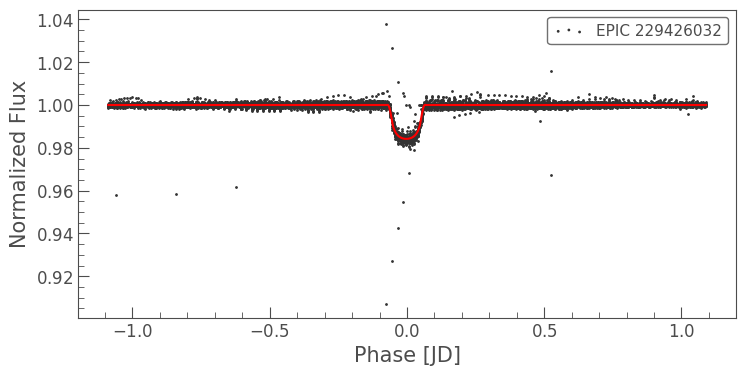

In [74]:
folded = lightcurve.fold(period=best_ts, epoch_time=epoch_time)
folded_fluxes = folded['flux'].unmasked.value
folded_times = folded['time'].value

popt, pcov = curve_fit(f=get_curve, xdata=folded_times, ydata=folded_fluxes,
                               p0=[0.1, 0.2, 0.1, 0.0, best_ts, 5, 0.5*np.pi],
                       bounds=([0,0,0,min(folded_times),best_ts-0.00001,0,0],
                               [1,np.inf,np.inf,max(folded_times),best_ts,np.inf,np.pi*2]))


r_planet, ldc1, ldc2, t0, time_period, orbital_radius, orbital_inclination = popt

fitted_curve = get_curve(folded_times, r_planet, ldc1, ldc2, t0, time_period,
                         orbital_radius, orbital_inclination)
print(popt)

ax = folded.scatter()

ax.plot(folded_times, fitted_curve, 'r-')

[ 1.05760455e-01  2.97872116e-01  1.30143853e+00 -2.28157906e-03
  2.18053258e+00  5.12978634e+00  1.65091216e+00]


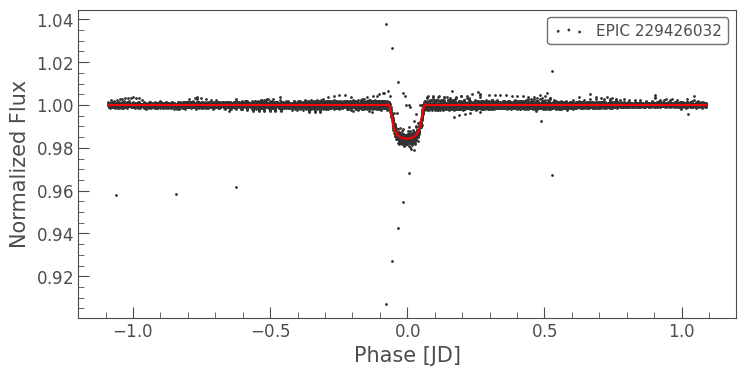

In [75]:
actual_tp = 2.18053539

folded = lightcurve.fold(period=actual_tp, epoch_time=epoch_time)
folded_fluxes = folded['flux'].unmasked.value
folded_times = folded['time'].value

popt, pcov = curve_fit(f=get_curve, xdata=folded_times, ydata=folded_fluxes,
                               p0=[0.1, 0.2, 0.1, 0.0, actual_tp, 5, 0.5*np.pi],
                       bounds=([0,0,0,min(folded_times),actual_tp-0.00001,0,0],
                               [1,np.inf,np.inf,max(folded_times),actual_tp,np.inf,np.pi*2]))


r_planet, ldc1, ldc2, t0, time_period, orbital_radius, orbital_inclination = popt

fitted_curve = get_curve(folded_times, r_planet, ldc1, ldc2, t0, time_period,
                         orbital_radius, orbital_inclination)
print(popt)

ax = folded.scatter()
ax.plot(folded_times, fitted_curve, 'r-')

[ 6.73266596e-02  1.04070028e+00  3.20484697e-01 -7.48350935e-04
  2.18053539e+00  4.68387269e+00  1.88848890e+00]


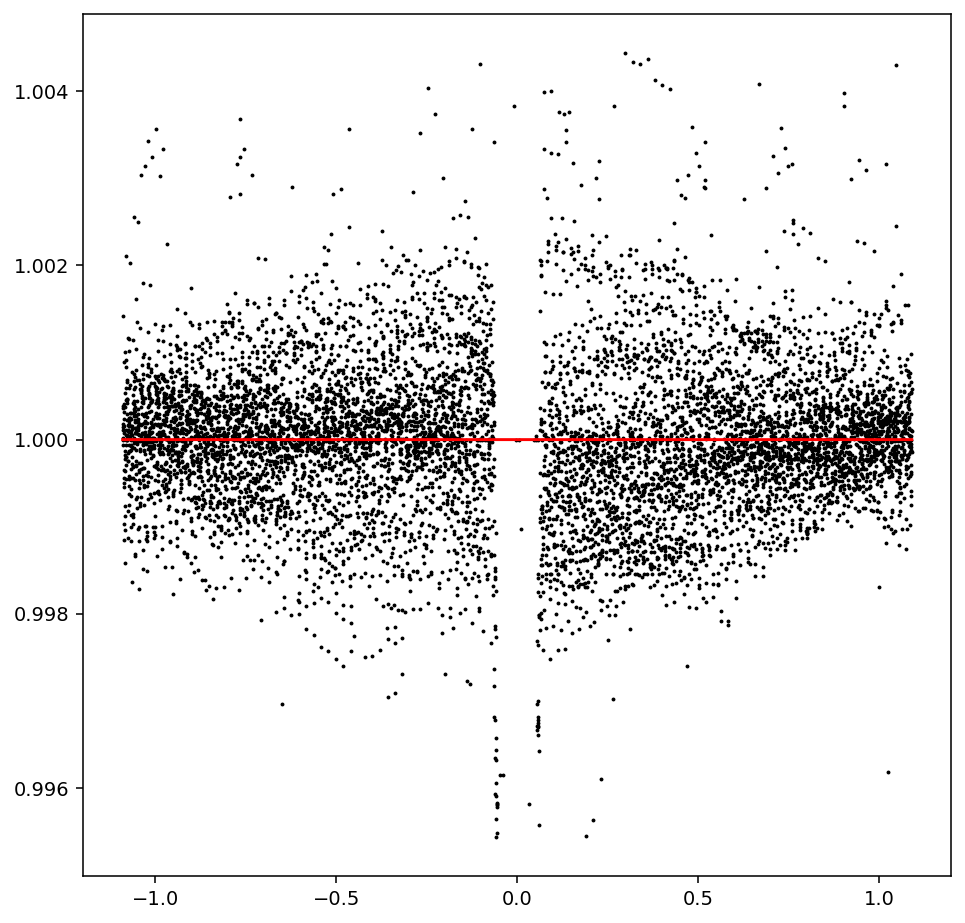

In [76]:
actual_tp = 2.18053539

folded = lightcurve.flatten().fold(period=actual_tp, epoch_time=epoch_time).remove_outliers()
folded_fluxes = folded['flux'].unmasked.value
folded_times = folded['time'].value

# folded_fluxes = gaussian_smooth(folded_fluxes)

popt, pcov = curve_fit(f=get_curve, xdata=folded_times, ydata=folded_fluxes,
                               p0=[0.1, 0.2, 0.1, 0.0, actual_tp, 5, 0.5*np.pi],
                       bounds=([0,0,0,min(folded_times),actual_tp-0.00001,0,0],
                               [1,np.inf,np.inf,max(folded_times),actual_tp,np.inf,np.pi*2]))


r_planet, ldc1, ldc2, t0, time_period, orbital_radius, orbital_inclination = popt#[0.1178, 0.2, 0.1, -0.009, actual_tp, 6.07, 1.5364]

fitted_curve = get_curve(folded_times, r_planet, ldc1, ldc2, t0, time_period,
                         orbital_radius, orbital_inclination)
print(popt)

fig, ax = plt.subplots()
ax.plot(folded_times, folded_fluxes, 'k.', markersize=2)
ax.plot(folded_times, fitted_curve, 'r-')

In [77]:
R_star = 1.261 * constants.R_sun
R_planet_actual = 1.445 * constants.R_jup

ratio = R_planet_actual/R_star
ratio

<Quantity 0.1177574>

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

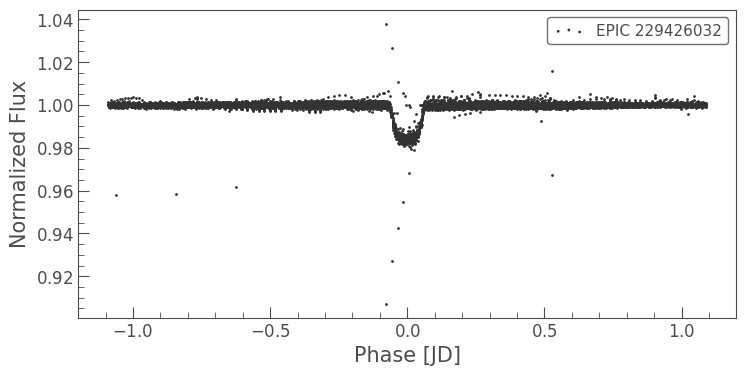

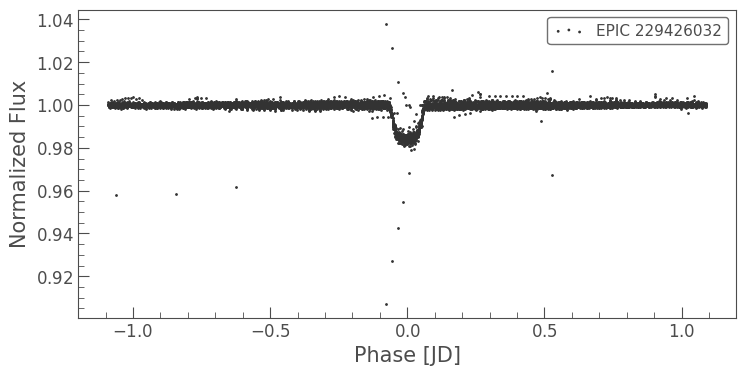

In [78]:
lightcurve.fold(period=actual_tp, epoch_time=epoch_time).scatter()
lightcurve.flatten().fold(period=actual_tp, epoch_time=epoch_time).scatter()

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

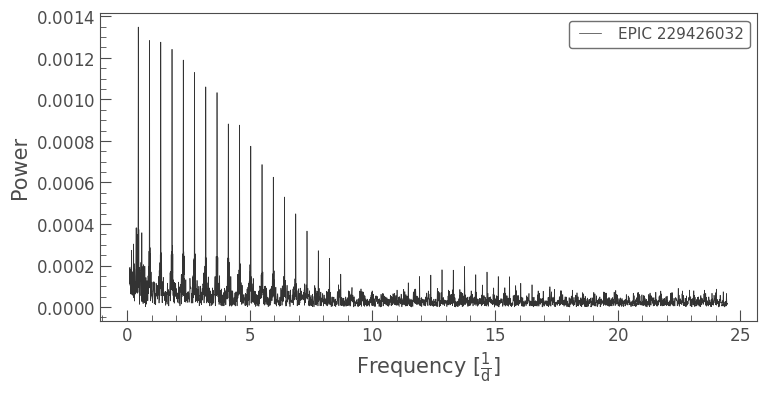

In [79]:
periodogram = lightcurve.to_periodogram(minimum_frequency=0.1)
periodogram.plot()

/usr/local/lib/python3.10/dist-packages/lightkurve/seismology/core.py:75: LightkurveWarning: Seismology received a periodogram which does not appear to have been background-corrected. Please consider calling `periodogram.flatten()` prior to extracting seismological parameters.
  warnings.warn(


array([<Axes: ylabel='Power'>,
       <Axes: ylabel='Frequency lag [$\\mathrm{\\frac{1}{d}}$]'>,
       <Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Correlation Metric'>],
      dtype=object)

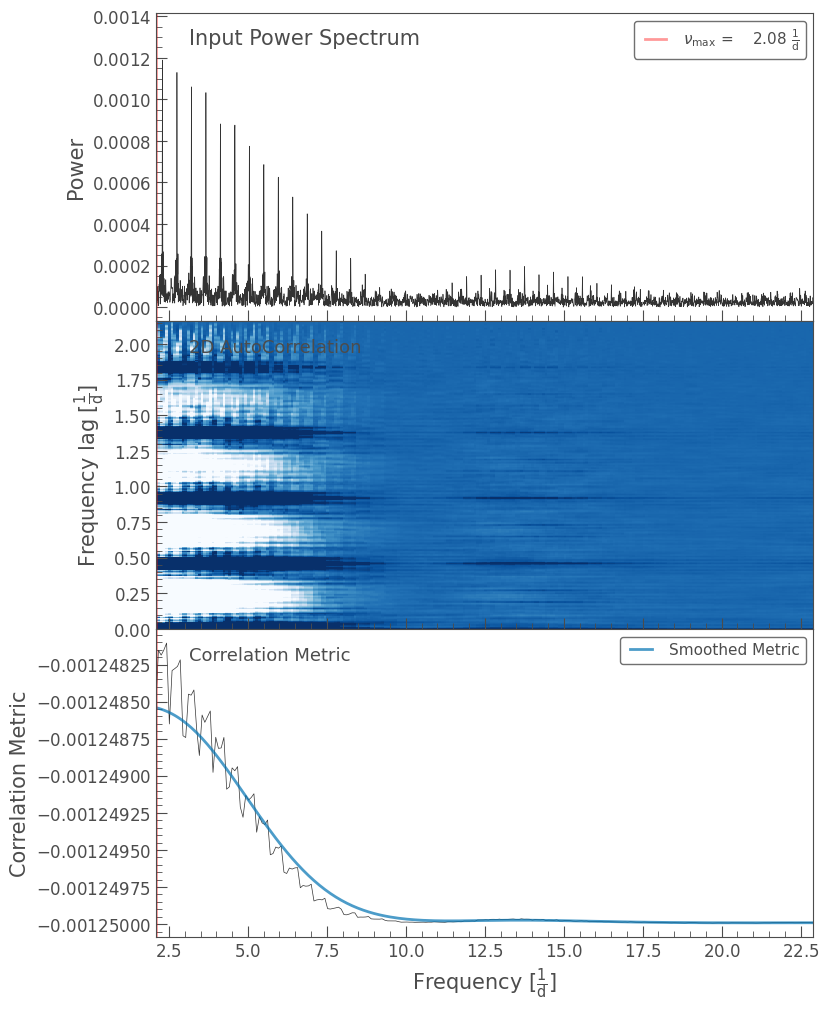

In [82]:
seismology = periodogram.to_seismology()
seismology.estimate_numax()
seismology.diagnose_numax()

<Axes: title={'center': 'Echelle diagram for EPIC 229426032'}, xlabel='Frequency mod. 0.24 1 / d', ylabel='Frequency [$\\mathrm{\\frac{1}{d}}$]'>

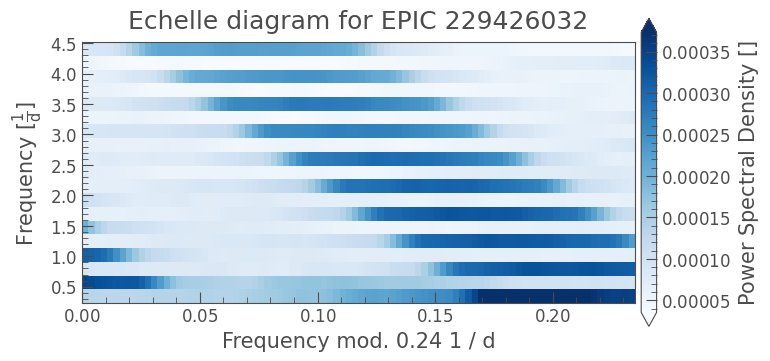

In [84]:
seismology.estimate_deltanu()
seismology.plot_echelle()

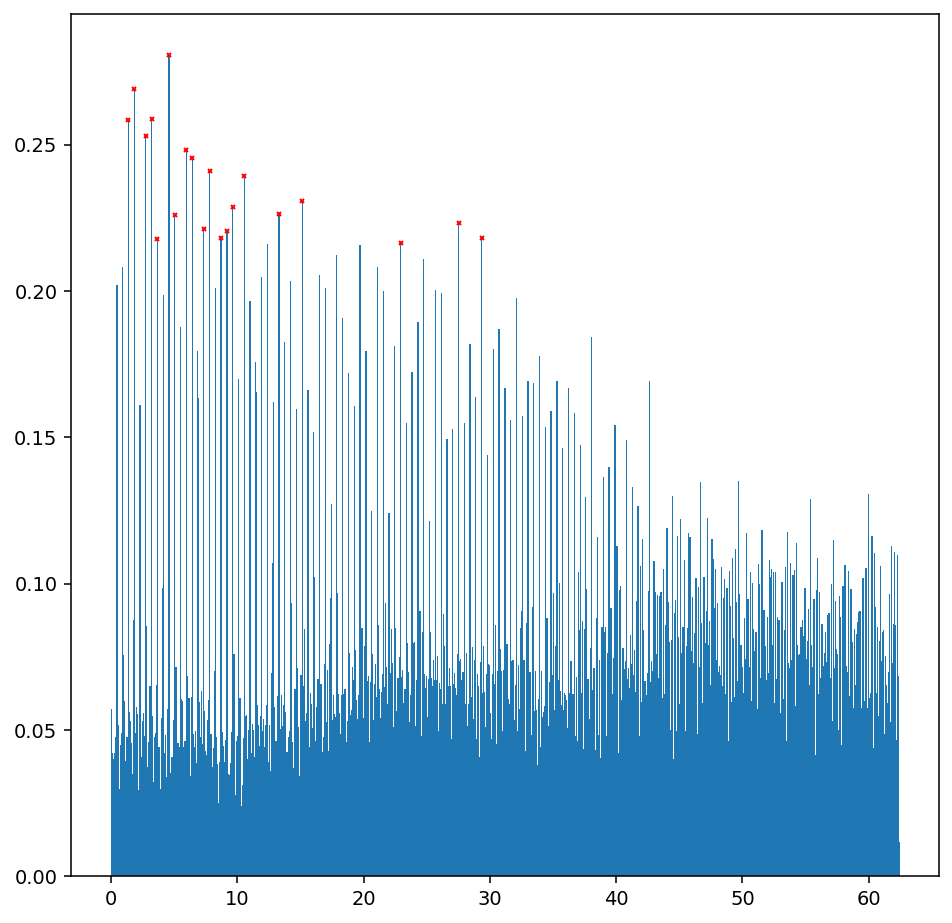

In [85]:
# freq = periodogram[]
peaks, properties = find_peaks(trans, height=0.01)

prominence_data = peak_prominences(trans,peaks)
prominences=prominence_data[0]
bases = prominence_data[1]
sorted_prominences = list(sorted(prominences, reverse=True))

# prominence_threshold = sorted_prominences[len(sorted_prominences)//6]
prominence_threshold = sorted_prominences[20]

best_prominences_indexes = np.where(prominences>prominence_threshold)

best_peaks = peaks[best_prominences_indexes]

fig, ax = plt.subplots()
ax.bar(freq, trans, width=0.1)
ax.plot(best_peaks*freq_spacing, trans[best_peaks], 'rx', markersize=2)

In [86]:
1/actual_tp

0.45860296722815397